In [2]:

%matplotlib widget            
# NB: must be *before* importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['STIXGeneral', 'DejaVu Serif'],
    'mathtext.fontset': 'stix',
    'font.size': 18,
    'axes.unicode_minus': True,
})
plt.ioff()                    # we'll display the figure manually as a widget

import sys, json, yaml, pickle, logging, numpy as np
import plotly.graph_objects as go
from ipywidgets import Dropdown, IntRangeSlider, FloatSlider, Label, VBox, HBox, Output, Button
from IPython.display import display

# ----------------------------------------------------------------------------- 
# 1.  Module-import PATHS (unchanged)
pkg_root = "/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation"
sys.path.insert(0, pkg_root)

# --- Your pipeline’s imports (unchanged) -------------------------------------
from scint_analysis import config, pipeline, plotting
from scint_analysis.analysis import lorentzian_component, gaussian_component
from scint_analysis.core import ACF
from scint_analysis.config import update_fitting_parameter, update_pipeline_parameter, update_yaml_guesses, update_yaml_config

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

In [1]:
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

# --- Physical and Astronomical Constants (SI Units) ---
C_LIGHT = 299792458.0  # Speed of light in m/s
PC_TO_M = 3.0857e16     # Parsecs to meters
KPC_TO_M = PC_TO_M * 1000

# --- Define the Planck 2018 Cosmology ---
# Using parameters from Planck Collaboration et al. (2018)
cosmo_planck18 = FlatLambdaCDM(H0=67.4, Om0=0.315)


def check_fourier_consistency(tau_s, nu_s, C_factor_range=(0.5, 2.0)):
    """
    Checks if scattering time and scintillation bandwidth are consistent with
    originating from the same screen via the Fourier uncertainty principle.

    Args:
        tau_s (float): The pulse broadening timescale in seconds.
        nu_s (float): The decorrelation bandwidth in Hertz.
        C_factor_range (tuple): The expected range for the constant C in the
                                relation 2 * pi * tau_s * nu_s = C[cite: 1128].

    Returns:
        tuple: A tuple containing the calculated C value and a boolean
               indicating if it falls within the expected range.
    """
    calculated_c = 2 * np.pi * tau_s * nu_s
    is_consistent = C_factor_range[0] <= calculated_c <= C_factor_range[1]
    return calculated_c, is_consistent


def estimate_host_screen_distance(redshift, nu_obs_hz, nu_s_mw_hz, tau_s_host_s, d_mw_m, m_mw=1.0):
    """
    Estimates the distance between an FRB and the screen in its host galaxy
    using the Planck 2018 cosmology.

    This function implements the formula from Pradeep et al. (2025),
    which provides an upper limit based on the coherence condition between two screens.
    It assumes the screens are isotropic and two-dimensional.

    Args:
        redshift (float): The spectroscopic redshift of the FRB host galaxy.
        nu_obs_hz (float): The reference observing frequency for the measurements (in Hz).
        nu_s_mw_hz (float): The scintillation bandwidth of the Milky Way screen (in Hz).
        tau_s_host_s (float): The scattering timescale from the host screen (in s).
        d_mw_m (float): The estimated distance to the Milky Way screen (in meters).
        m_mw (float): The modulation index of the MW scintillation. A value < 1 indicates
                      a resolved system. Defaults to 1.0.

    Returns:
        float: The estimated upper limit on the distance between the FRB and the
               host galaxy screen (d_h,FRB) in parsecs.
    """
    # Calculate the angular diameter distance to the FRB using the defined cosmology
    d_frb_m = cosmo_planck18.angular_diameter_distance(redshift).to(u.m).value

    # The Pradeep et al. formula:
    # D_h,FRB * D_MW <= (1+z)*D_FRB^2 / (8*pi*nu^2) * nu_s,MW / (m_MW*tau_s,h)
    numerator = (1 + redshift) * d_frb_m**2 * nu_s_mw_hz
    denominator = 8 * np.pi * nu_obs_hz**2 * m_mw * tau_s_host_s
    
    d_h_d_mw_product_m2 = numerator / denominator
    
    # Solve for the host screen distance
    d_h_frb_m = d_h_d_mw_product_m2 / d_mw_m

    # Convert the final result from meters to parsecs
    d_h_frb_pc = d_h_frb_m / PC_TO_M

    return d_h_frb_pc

In [18]:
taus = np.array([0.276,
                0.151,
                0.831,
                0.284,
                0.307,
                0.568,
                0.143,
                0.243,
                0.208,
                0.130,
                0.023,
                0.156])
sbws = np.array([1.072,
                11.463,
                 0.405,
                 0.060,
                 0.119,
                 6.229,
                 0.848,
                 0.099,
                 1.681,
                 0.229,
                 6.978,
                 0.4242
])

ms = np.array([0.7846,
               0.4662,
               0.7615,
               1.837,
               0.1937,
               0.53,
               0.1713,
               1.208,
               0.9527,
               0.6207,
               0.739,
               0.4372
])
               

names = np.array([
'zach',
'whitney',
'oran',
'isha',
'wilhelm',
'phineas',
'freya',
'hamilton',
'mahi',
'chromatica',
'casey',
'johndoeII',
])

zs = np.array([
0.0430,
0.4790,
0.3005,
0.2505,
0.5100,
0.2710,
1.0,
0.3024,
1.0,
0.0740,
0.287,
1.0,
])

dms = np.array([
262.368,
462.174,
396.882,
411.568,
602.346,
610.274,
912.4,
518.799,
960.128,
272.368,
491.211,
696.506,
])


In [23]:
screendists = []

for i in range(len(taus)):
    print(f'{names[i]}')
    print('--------------- \n')
    tau_ms = taus[i]*(1.4/1)**(-4)
    print('Tau (1.4 GHz) =', tau_ms, 'ms')
    bw_kHz = sbws[i]*1e3  # Convert to kHz
    print('BW (1.4 GHz) =', bw_kHz, 'kHz')

    # Check Fourier consistency
    calculated_c, is_consistent = check_fourier_consistency(tau_s=tau_ms, nu_s=bw_kHz)
    print(f"Calculated C: {calculated_c:.3f}, Consistent: {is_consistent}")

    # --- Your measured and model-based inputs ---
    frb_redshift = zs[i]
    observing_freq_hz = 1400e6  # 1400 MHz in Hz

    # The value you measured that is consistent with the MW
    nu_s_mw_hz = bw_kHz * 1e3  # Convert from kHz to Hz

    # The pulse broadening you measured
    tau_s_host_s = tau_ms * 1e-3  # Convert from ms to seconds

    # Estimated from NE2001 for the FRB's line of sight
    dist_to_mw_screen_m = 0.5 * KPC_TO_M # Example: 0.5 kpc

    # Measured from the ACF of the MW scintillation.
    # If not available, use the conservative assumption of 1.0.
    m_mw = ms[i]

    # --- Run your function ---
    d_h_frb_limit_pc = estimate_host_screen_distance(
        redshift=frb_redshift,
        nu_obs_hz=observing_freq_hz,
        nu_s_mw_hz=nu_s_mw_hz,
        tau_s_host_s=tau_s_host_s,
        d_mw_m=dist_to_mw_screen_m,
        m_mw=m_mw
    )

    screendists.append(float(d_h_frb_limit_pc/1000))

    print(f"The estimated upper limit for the host screen distance is: {d_h_frb_limit_pc / 1000:.2f} kpc \n")

    

zach
--------------- 

Tau (1.4 GHz) = 0.07184506455643484 ms
BW (1.4 GHz) = 1072.0 kHz
Calculated C: 483.918, Consistent: False
The estimated upper limit for the host screen distance is: 26.53 kpc 

whitney
--------------- 

Tau (1.4 GHz) = 0.03930653894210746 ms
BW (1.4 GHz) = 11463.0 kHz
Calculated C: 2831.020, Consistent: False
The estimated upper limit for the host screen distance is: 60711.26 kpc 

oran
--------------- 

Tau (1.4 GHz) = 0.21631611828404837 ms
BW (1.4 GHz) = 405.0 kHz
Calculated C: 550.457, Consistent: False
The estimated upper limit for the host screen distance is: 117.70 kpc 

isha
--------------- 

Tau (1.4 GHz) = 0.07392753019575178 ms
BW (1.4 GHz) = 60.0 kHz
Calculated C: 27.870, Consistent: False
The estimated upper limit for the host screen distance is: 15.70 kpc 

wilhelm
--------------- 

Tau (1.4 GHz) = 0.07991461890878802 ms
BW (1.4 GHz) = 119.0 kHz
Calculated C: 59.752, Consistent: False
The estimated upper limit for the host screen distance is: 814.39

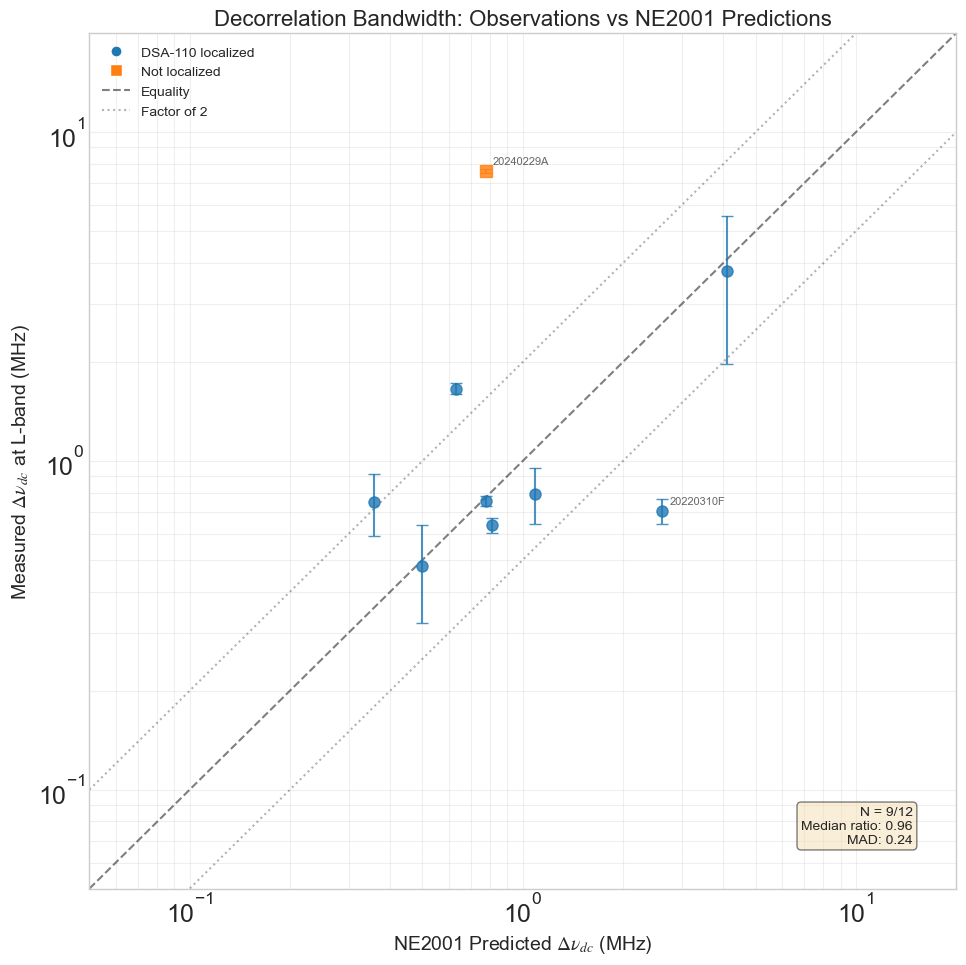

Summary Statistics:
Total FRBs: 12
FRBs with measurements: 9
Median measured/predicted ratio: 0.96
FRBs within factor of 2: 5/9
FRBs within factor of 3: 7/9


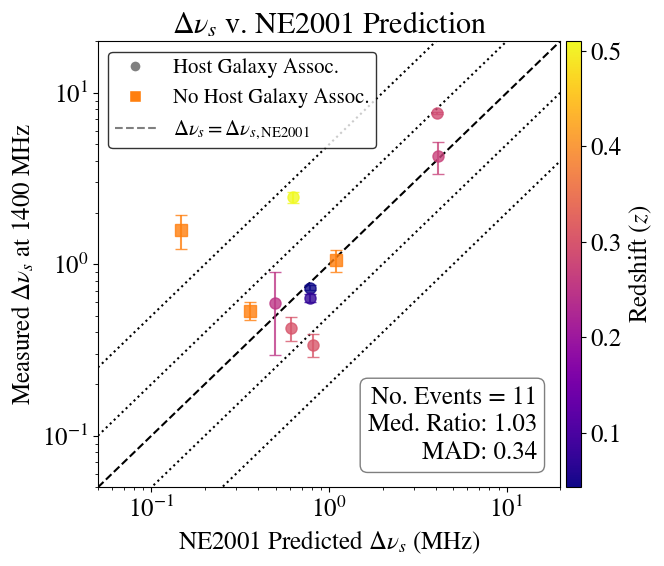

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from adjustText import adjust_text
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.lines import Line2D

# --- Plotting Setup ---
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['STIXGeneral', 'DejaVu Serif'],
    'mathtext.fontset': 'stix',
    'font.size': 18,
    'axes.unicode_minus': True,
})

# --- Data Loading and Parsing ---

# Use the filename from your script
df = pd.read_csv('DSA110_CHIMECodetectionBurstProps.csv')

# Function to extract gamma values from the text
def extract_gamma_values(text):
    if pd.isna(text) or text == 'None' or text == '' or str(text).strip() == '':
        return [], []  # Return empty lists for both values and errors
    
    gamma_values = []
    gamma_errors = []
    
    # Find all gamma values with their errors
    gamma_pattern = r'l_\d_gamma:\s*([\d.]+)\s*±\s*([\d.]+)'
    matches = re.findall(gamma_pattern, str(text))
    
    for match in matches:
        gamma_values.append(float(match[0]))
        gamma_errors.append(float(match[1]))
    
    return gamma_values, gamma_errors

# Function to extract NE2001 prediction
def extract_ne2001(text):
    if pd.isna(text):
        return np.nan
    match = re.search(r'gamma:\s*([\d.]+)', text)
    if match:
        return float(match.group(1))
    return np.nan

# --- Data Processing Loop ---
tns_names = []
measured_gammas = []
measured_gammas_err = []
ne2001_predictions = []
has_localization = []
redshifts = []

for _, row in df.iterrows():
    tns_name = row['TNS Name'].rstrip("'")
    tns_names.append(tns_name)
    
    all_gammas = []
    all_errors = []
    
    for col in ['bw_MHz_1.4GHz_component1', 'bw_MHz_1.4GHz_component2']:
        gammas, errors = extract_gamma_values(row[col])
        all_gammas.extend(gammas)
        all_errors.extend(errors)
    
    if all_gammas:
        measured_gammas.append(np.mean(all_gammas))
        # --- EDITED: Correct error propagation ---
        # Combine errors in quadrature for the error on the mean
        if all_errors:
            error_on_mean = np.sqrt(np.sum(np.array(all_errors)**2)) / len(all_errors)
            measured_gammas_err.append(error_on_mean)
        else:
            measured_gammas_err.append(np.nan)
    else:
        measured_gammas.append(np.nan)
        measured_gammas_err.append(np.nan)
    
    ne2001_predictions.append(extract_ne2001(row['NE2001: bw_MHz_1.4GHz']))
    has_localization.append(not pd.isna(row['Localization']) and row['Localization'] != '')
    redshifts.append(row['Redshift'])

# Convert lists to numpy arrays for easier manipulation
measured_gammas = np.array(measured_gammas)
measured_gammas_err = np.array(measured_gammas_err)
ne2001_predictions = np.array(ne2001_predictions)
has_localization = np.array(has_localization)
redshifts = np.array(redshifts, dtype=float) # Ensure redshift is float

# --- Plotting ---
fig, ax = plt.subplots(figsize=(7, 6))

# Plot limits and equality/factor lines
plot_min, plot_max = 0.05, 20
ax.set_xlim(plot_min, plot_max)
ax.set_ylim(plot_min, plot_max)
x_line = np.logspace(np.log10(plot_min), np.log10(plot_max), 100)
ax.plot(x_line, x_line, 'k--')#, alpha=0.5)
ax.plot(x_line, 2*x_line, 'k:')#, alpha=0.3)
ax.plot(x_line, x_line/2, 'k:')#, alpha=0.3)
ax.plot(x_line, 5*x_line, 'k:')#, alpha=0.15)
ax.plot(x_line, x_line/5, 'k:')#, alpha=0.15)

# --- Redshift Colormap Setup ---
# Create a colormap for localized bursts based on their redshift
valid_redshifts = redshifts[has_localization & ~np.isnan(redshifts)]
if len(valid_redshifts) > 0:
    norm = colors.Normalize(vmin=np.min(valid_redshifts), vmax=np.max(valid_redshifts))
    cmap = cm.plasma
else: # Fallback if no valid redshifts
    norm = colors.Normalize(vmin=0.2, vmax=0.8)
    cmap = cm.plasma

# Plot data points and collect text labels
texts = []
for i in range(len(tns_names)):
    if not np.isnan(measured_gammas[i]) and not np.isnan(ne2001_predictions[i]):
        # Determine marker and color based on localization status
        if has_localization[i] and not np.isnan(redshifts[i]):
            marker = 'o'
            point_color = cmap(norm(redshifts[i]))
        else:
            marker = 's'
            point_color = '#ff7f0e' # Orange for non-localized
            
        ax.errorbar(ne2001_predictions[i], measured_gammas[i], 
                   yerr=measured_gammas_err[i], 
                   fmt=marker, color=point_color, 
                   markersize=8, capsize=4, alpha=0.8, ecolor=point_color)
        
        # Add labels to a list for later adjustment
        #short_name = tns_names[i].replace('FRB ', '')
        #texts.append(ax.text(ne2001_predictions[i], measured_gammas[i], short_name)) #, #fontsize=8, alpha=0.9))

# --- Automatic Label Adjustment ---
if texts:
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5, alpha=0.5))

# Axes settings
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('NE2001 Predicted $\Delta\\nu_{s}$ (MHz)') #, fontsize=14)
ax.set_ylabel('Measured $\Delta\\nu_{s}$ at 1400 MHz')#, fontsize=14)
ax.set_title('$\\Delta\\nu_{s}$ v. NE2001 Prediction')#, fontsize=16)

# --- Updated Legend and Colorbar ---
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=8, label='Host Galaxy Assoc.'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#ff7f0e', 
           markersize=8, label='No Host Galaxy Assoc.'),
    Line2D([0], [0], color='k', linestyle='--', alpha=0.5, label='$\Delta\\nu_{s} = \Delta\\nu_{s,\mathregular{NE2001}}$'),
]
ax.legend(loc='upper left', frameon=True,          # draw the legend patch
        handles=legend_elements,
        fancybox=True,         # use a FancyBboxPatch (i.e. rounded corners)
        framealpha=0.8,        # overall opacity of the legend background
        facecolor='white',     # background color
        edgecolor='black',     # border color
        borderpad=0.3,
        fontsize='small')

# Add colorbar for redshift
if len(valid_redshifts) > 0:
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, pad=0.01, aspect=30)
    cbar.set_label('Redshift ($z$)') #fontsize=12)

# Statistics Box
valid_mask = ~np.isnan(measured_gammas) & ~np.isnan(ne2001_predictions)
if np.sum(valid_mask) > 0:
    ratios = measured_gammas[valid_mask] / ne2001_predictions[valid_mask]
    median_ratio = np.median(ratios)
    mad_ratio = np.median(np.abs(ratios - median_ratio))
    
    textstr = f'No. Events = {np.sum(valid_mask)}\n'
    textstr += f'Med. Ratio: {median_ratio:.2f}\n'
    textstr += f'MAD: {mad_ratio:.2f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.95, 0.05, textstr, transform=ax.transAxes, #fontsize=10,
            verticalalignment='bottom', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()


In [51]:
!pip install adjustText

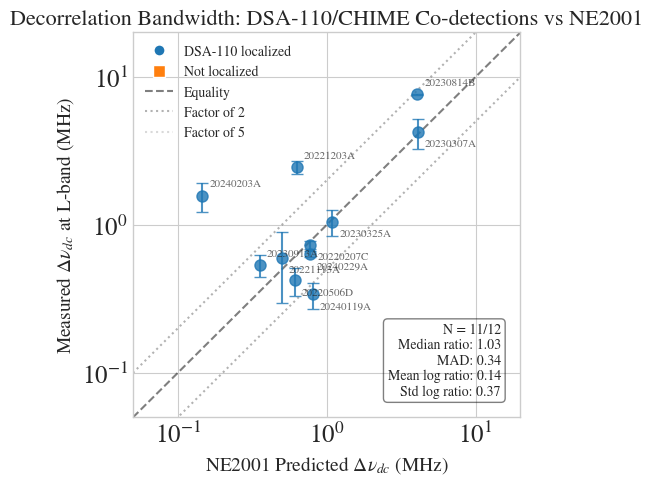


Detailed Summary Statistics:
Total FRBs: 12
FRBs with measurements: 11
FRBs with localizations: 12

Median measured/predicted ratio: 1.03
FRBs within factor of 2: 8/11
FRBs within factor of 3: 9/11
FRBs within factor of 5: 10/11

Individual FRB ratios (measured/predicted):
FRB 20220207C: 0.94 (Localized, z=0.043)
FRB 20220506D: 0.69 (Localized, z=0.300)
FRB 20221113A: 1.20 (Localized, z=0.251)
FRB 20221203A: 3.90 (Localized, z=0.510)
FRB 20230307A: 1.03 (Localized, z=0.271)
FRB 20230325A: 0.97 (Localized, z=nan)
FRB 20230913A: 1.50 (Localized, z=nan)
FRB 20240119A: 0.42 (Localized, z=0.302)
FRB 20240203A: 10.76 (Localized, z=nan)
FRB 20240229A: 0.82 (Localized, z=0.074)
FRB 20230814B: 1.87 (Localized, z=0.287)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['STIXGeneral', 'DejaVu Serif'],
    'mathtext.fontset': 'stix',
    'font.size': 18,
    'axes.unicode_minus': True,
})

# Read the CSV file
df = pd.read_csv('DSA110_CHIMECodetectionBurstProps.csv')

# Function to extract gamma values from the text
def extract_gamma_values(text):
    if pd.isna(text) or text == 'None' or text == '' or str(text).strip() == '':
        return [], []  # Return empty lists for both values and errors
    
    gamma_values = []
    gamma_errors = []
    
    # Find all gamma values with their errors
    gamma_pattern = r'l_\d_gamma:\s*([\d.]+)\s*±\s*([\d.]+)'
    matches = re.findall(gamma_pattern, str(text))  # Convert to string to be safe
    
    for match in matches:
        gamma_values.append(float(match[0]))
        gamma_errors.append(float(match[1]))
    
    return gamma_values, gamma_errors

# Function to extract NE2001 prediction
def extract_ne2001(text):
    if pd.isna(text):
        return np.nan
    match = re.search(r'gamma:\s*([\d.]+)', text)
    if match:
        return float(match.group(1))
    return np.nan

# Process the data
tns_names = []
measured_gammas = []
measured_gammas_err = []
ne2001_predictions = []
has_localization = []
redshifts = []

for _, row in df.iterrows():
    tns_name = row['TNS Name'].rstrip("'")  # Remove trailing apostrophe if present
    tns_names.append(tns_name)
    
    # Extract measured values from both components
    all_gammas = []
    all_errors = []
    
    for col in ['bw_MHz_1.4GHz_component1', 'bw_MHz_1.4GHz_component2']:
        gammas, errors = extract_gamma_values(row[col])
        all_gammas.extend(gammas)
        all_errors.extend(errors)
    
    # Take average if multiple values exist
    if all_gammas:
        measured_gammas.append(np.mean(all_gammas))
        measured_gammas_err.append(np.mean(all_errors))
    else:
        measured_gammas.append(np.nan)
        measured_gammas_err.append(np.nan)
    
    # Extract NE2001 prediction
    ne2001_predictions.append(extract_ne2001(row['NE2001: bw_MHz_1.4GHz']))
    
    # Check if localized (has coordinates)
    has_localization.append(not pd.isna(row['Localization']) and row['Localization'] != '')
    
    # Store redshift
    redshifts.append(row['Redshift'])

# Convert to arrays
measured_gammas = np.array(measured_gammas)
measured_gammas_err = np.array(measured_gammas_err)
ne2001_predictions = np.array(ne2001_predictions)
has_localization = np.array(has_localization)
redshifts = np.array(redshifts)

# Create the figure
fig, ax = plt.subplots(figsize=(5, 5))

# Plot limits
plot_min = 0.05
plot_max = 20
ax.set_xlim(plot_min, plot_max)
ax.set_ylim(plot_min, plot_max)

# Plot equality line
x_line = np.logspace(np.log10(plot_min), np.log10(plot_max), 100)
ax.plot(x_line, x_line, 'k--', alpha=0.5) #, label='Equality')

# Plot factor of 2 lines
ax.plot(x_line, 2*x_line, 'k:', alpha=0.3)
ax.plot(x_line, x_line/2, 'k:', alpha=0.3)

# Plot factor of 5 lines (lighter)
#ax.plot(x_line, 5*x_line, 'k:', alpha=0.15)
#ax.plot(x_line, x_line/5, 'k:', alpha=0.15)

# Color code by whether DSA-110 localized to host
colors = ['#1f77b4' if loc else '#ff7f0e' for loc in has_localization]
markers = ['o' if loc else 's' for loc in has_localization]

# Plot the data points
for i in range(len(tns_names)):
    if not np.isnan(measured_gammas[i]) and not np.isnan(ne2001_predictions[i]):
        ax.errorbar(ne2001_predictions[i], measured_gammas[i], 
                   yerr=measured_gammas_err[i], 
                   fmt=markers[i], color=colors[i], 
                   markersize=8, capsize=4, alpha=0.8)

# Add labels for all FRBs
for i in range(len(tns_names)):
    if not np.isnan(measured_gammas[i]) and not np.isnan(ne2001_predictions[i]):
        # Create short label
        short_name = tns_names[i]
        
        # Position text to avoid overlaps
        ratio = measured_gammas[i] / ne2001_predictions[i]
        if ratio > 1.5:
            va = 'bottom'
            offset_y = 5
        else:
            va = 'top'
            offset_y = -5
            
        ax.annotate(short_name, 
                   (ne2001_predictions[i], measured_gammas[i]),
                   xytext=(5, offset_y), textcoords='offset points',
                   fontsize=8, alpha=0.7, va=va)

# Logarithmic axes
ax.set_xscale('log')
ax.set_yscale('log')

# Labels and title
ax.set_xlabel('NE2001 Predicted $\Delta\\nu_{dc}$ (MHz)', fontsize=14)
ax.set_ylabel('Measured $\Delta\\nu_{dc}$ at L-band (MHz)', fontsize=14)
ax.set_title('Decorrelation Bandwidth: DSA-110/CHIME Co-detections vs NE2001', fontsize=16)

# Grid
#ax.grid(True, alpha=0.3, which='both')

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#1f77b4', 
           markersize=8, label='DSA-110 localized'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#ff7f0e', 
           markersize=8, label='Not localized'),
    Line2D([0], [0], color='k', linestyle='--', alpha=0.5, label='Equality'),
    Line2D([0], [0], color='k', linestyle=':', alpha=0.3, label='Factor of 2'),
    Line2D([0], [0], color='k', linestyle=':', alpha=0.15, label='Factor of 5')
]
ax.legend(handles=legend_elements, loc='upper left')#, fontsize=10)

# Add statistics box
valid_mask = ~np.isnan(measured_gammas) & ~np.isnan(ne2001_predictions)
if np.sum(valid_mask) > 0:
    ratios = measured_gammas[valid_mask] / ne2001_predictions[valid_mask]
    log_ratios = np.log10(ratios)
    median_ratio = np.median(ratios)
    mad_ratio = np.median(np.abs(ratios - median_ratio))
    mean_log_ratio = np.mean(log_ratios)
    std_log_ratio = np.std(log_ratios)
    
    textstr = f'N = {np.sum(valid_mask)}/{len(tns_names)}\n'
    textstr += f'Median ratio: {median_ratio:.2f}\n'
    textstr += f'MAD: {mad_ratio:.2f}\n'
    textstr += f'Mean log ratio: {mean_log_ratio:.2f}\n'
    textstr += f'Std log ratio: {std_log_ratio:.2f}'
    props = dict(boxstyle='round', facecolor='none', alpha=0.5)
    ax.text(0.95, 0.05, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='bottom', horizontalalignment='right', bbox=props)

#plt.tight_layout()
plt.show()

# Print detailed summary statistics
print("\nDetailed Summary Statistics:")
print(f"Total FRBs: {len(tns_names)}")
print(f"FRBs with measurements: {np.sum(valid_mask)}")
print(f"FRBs with localizations: {np.sum(has_localization)}")
print(f"\nMedian measured/predicted ratio: {median_ratio:.2f}")
print(f"FRBs within factor of 2: {np.sum((ratios >= 0.5) & (ratios <= 2))}/{np.sum(valid_mask)}")
print(f"FRBs within factor of 3: {np.sum((ratios >= 0.33) & (ratios <= 3))}/{np.sum(valid_mask)}")
print(f"FRBs within factor of 5: {np.sum((ratios >= 0.2) & (ratios <= 5))}/{np.sum(valid_mask)}")

print("\nIndividual FRB ratios (measured/predicted):")
for i in range(len(tns_names)):
    if not np.isnan(measured_gammas[i]) and not np.isnan(ne2001_predictions[i]):
        ratio = measured_gammas[i] / ne2001_predictions[i]
        loc_status = "Localized" if has_localization[i] else "Not localized"
        print(f"{tns_names[i]}: {ratio:.2f} ({loc_status}, z={redshifts[i]:.3f})")

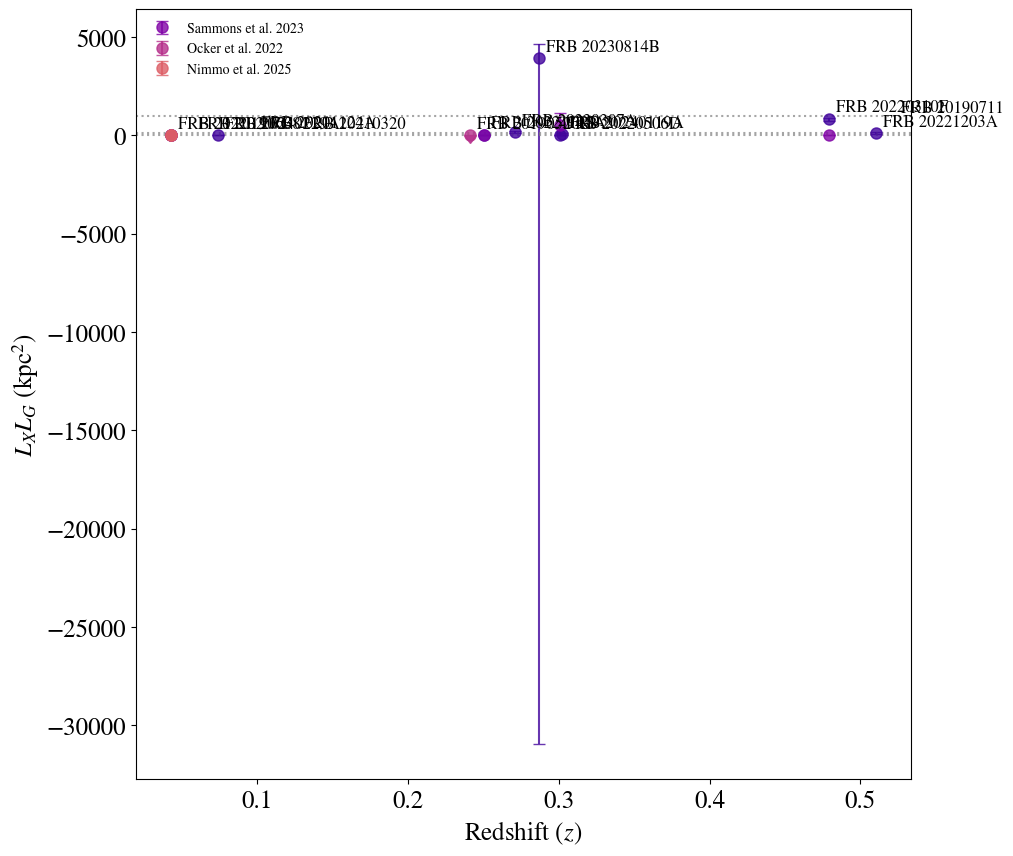

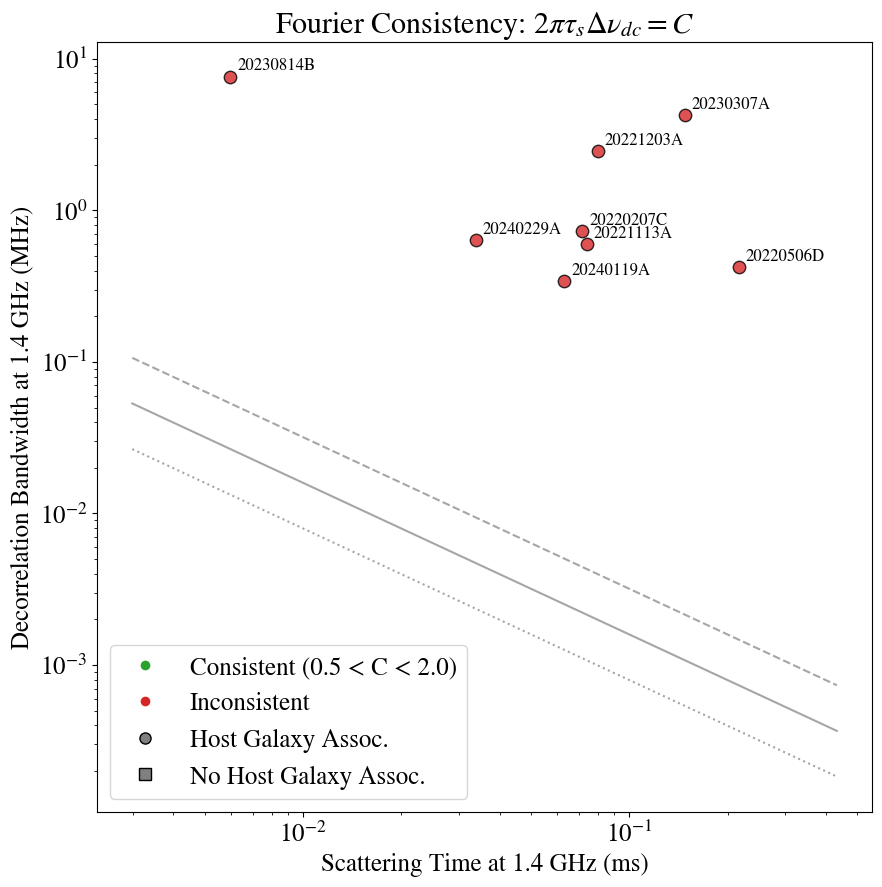


Two-Screen Scattering Analysis Summary:
Total FRBs analyzed: 9

L_X L_G Upper Limits:
  Median: 80.5 pc
  Min: 2.0 pc
  Max: 3935.5 pc
  < 100 pc: 5
  < 1 kpc: 8

Fourier Consistency Check:
  Consistent (0.5 < C < 2.0): 0/8
  Mean C value: 865.10

Individual FRB Results:

FRB 20220207C:
  z = 0.043
  τ(1GHz) = 0.28 ms
  d_host < 2.0 pc
  C = 329.77 ✗

FRB 20220310F:
  z = 0.479
  τ(1GHz) = 0.15 ms
  d_host < 843.7 pc

FRB 20220506D:
  z = 0.300
  τ(1GHz) = 0.83 ms
  d_host < 17.7 pc
  C = 573.90 ✗

FRB 20221113A:
  z = 0.251
  τ(1GHz) = 0.28 ms
  d_host < 31.1 pc
  C = 276.56 ✗

FRB 20221203A:
  z = 0.510
  τ(1GHz) = 0.31 ms
  d_host < 108.7 pc
  C = 1232.09 ✗

FRB 20230307A:
  z = 0.271
  τ(1GHz) = 0.57 ms
  d_host < 146.7 pc
  C = 3951.04 ✗

FRB 20240119A:
  z = 0.302
  τ(1GHz) = 0.24 ms
  d_host < 80.5 pc
  C = 134.95 ✗

FRB 20240229A:
  z = 0.074
  τ(1GHz) = 0.13 ms
  d_host < 11.8 pc
  C = 135.38 ✗

FRB 20230814B:
  z = 0.287
  τ(1GHz) = 0.02 ms
  d_host < 3935.5 pc
  C = 287.08 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

# --- Plotting Setup ---
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['STIXGeneral', 'DejaVu Serif'],
    'mathtext.fontset': 'stix',
    'font.size': 18,
    'axes.unicode_minus': True,
})

# --- Physical and Astronomical Constants (SI Units) ---
C_LIGHT = 299792458.0  # Speed of light in m/s
PC_TO_M = 3.0857e16     # Parsecs to meters
KPC_TO_M = PC_TO_M * 1000

# --- Define the Planck 2018 Cosmology ---
cosmo_planck18 = FlatLambdaCDM(H0=67.4, Om0=0.315)

def check_fourier_consistency(tau_s, nu_s, C_factor_range=(0.5, 2.0)):
    """
    Checks if scattering time and scintillation bandwidth are consistent with
    originating from the same screen via the Fourier uncertainty principle.
    """
    calculated_c = 2 * np.pi * tau_s * nu_s
    is_consistent = C_factor_range[0] <= calculated_c <= C_factor_range[1]
    return calculated_c, is_consistent

def estimate_host_screen_distance(redshift, nu_obs_hz, nu_s_mw_hz, tau_s_host_s, d_mw_m, m_mw=1.0):
    """
    Estimates the distance between an FRB and the screen in its host galaxy
    using the Planck 2018 cosmology.
    """
    # Calculate the angular diameter distance to the FRB using the defined cosmology
    d_frb_m = cosmo_planck18.angular_diameter_distance(redshift).to(u.m).value

    # The Pradeep et al. formula:
    numerator = (1 + redshift) * d_frb_m**2 * nu_s_mw_hz
    denominator = 8 * np.pi * nu_obs_hz**2 * m_mw * tau_s_host_s
    
    d_h_d_mw_product_m2 = numerator / denominator
    
    # Solve for the host screen distance
    d_h_frb_m = d_h_d_mw_product_m2 / d_mw_m

    # Convert the final result from meters to parsecs
    d_h_frb_pc = d_h_frb_m / PC_TO_M

    return d_h_frb_pc * 1e-3  # Return in kpc for consistency with other values

# Function to extract gamma values from the text
def extract_gamma_values(text):
    if pd.isna(text) or text == 'None' or text == '' or str(text).strip() == '':
        return [], []
    
    gamma_values = []
    gamma_errors = []
    
    gamma_pattern = r'l_\d_gamma:\s*([\d.]+)\s*±\s*([\d.]+)'
    matches = re.findall(gamma_pattern, str(text))
    
    for match in matches:
        gamma_values.append(float(match[0]))
        gamma_errors.append(float(match[1]))
    
    return gamma_values, gamma_errors

# Function to extract NE2001 prediction
def extract_ne2001(text):
    if pd.isna(text):
        return np.nan
    match = re.search(r'gamma:\s*([\d.]+)', text)
    if match:
        return float(match.group(1))
    return np.nan

# Function to parse tau error strings
def parse_tau_error(tau_err_str):
    """Parse error strings like '(+0.012, -0.002)' """
    if pd.isna(tau_err_str) or tau_err_str == '':
        return np.nan, np.nan
    
    match = re.search(r'\+?([\d.]+).*?-([\d.]+)', str(tau_err_str))
    if match:
        err_plus = float(match.group(1))
        err_minus = float(match.group(2))
        return err_plus, err_minus
    return np.nan, np.nan

# Read the CSV file
df = pd.read_csv('DSA110_CHIMECodetectionBurstProps.csv')

# Process the data for two-screen analysis
frb_names = []
redshifts = []
tau_1ghz_values = []
tau_errors_plus = []
tau_errors_minus = []
ne2001_bw_mhz = []
measured_bw_mhz = []
has_localization = []

for _, row in df.iterrows():
    frb_name = row['TNS Name'].rstrip("'")
    frb_names.append(frb_name)
    redshifts.append(row['Redshift'])
    
    # Extract tau at 1 GHz
    tau_1ghz_values.append(row['tau_1GHz'])
    
    # Parse tau errors
    err_plus, err_minus = parse_tau_error(row['tau_1GHz_err'])
    tau_errors_plus.append(err_plus)
    tau_errors_minus.append(err_minus)
    
    # Extract NE2001 bandwidth
    ne2001_bw_mhz.append(extract_ne2001(row['NE2001: bw_MHz_1.4GHz']))
    
    # Extract measured bandwidths and average
    all_gammas = []
    for col in ['bw_MHz_1.4GHz_component1', 'bw_MHz_1.4GHz_component2']:
        gammas, _ = extract_gamma_values(row[col])
        all_gammas.extend(gammas)
    
    if all_gammas:
        measured_bw_mhz.append(np.mean(all_gammas))
    else:
        measured_bw_mhz.append(np.nan)
    
    # Check localization
    has_localization.append(not pd.isna(row['Localization']) and row['Localization'] != '')

# Convert to arrays
redshifts = np.array(redshifts, dtype=float)
tau_1ghz_values = np.array(tau_1ghz_values, dtype=float)
tau_errors_plus = np.array(tau_errors_plus, dtype=float)
tau_errors_minus = np.array(tau_errors_minus, dtype=float)
ne2001_bw_mhz = np.array(ne2001_bw_mhz, dtype=float)
measured_bw_mhz = np.array(measured_bw_mhz, dtype=float)
has_localization = np.array(has_localization, dtype=bool)

# Calculate host screen distances
# Typical MW screen distance: 1 kpc
d_mw_m = 1 * KPC_TO_M
nu_obs_hz = 1.4e9  # 1.4 GHz observation frequency
m_mw = 1.0  # Modulation index

host_screen_distances = []
fourier_c_values = []
fourier_consistent = []

for i in range(len(frb_names)):
    if not np.isnan(redshifts[i]) and not np.isnan(tau_1ghz_values[i]) and not np.isnan(ne2001_bw_mhz[i]):
        # Convert tau from ms to s
        tau_host_s = tau_1ghz_values[i] * 1e-3
        
        # Convert bandwidth from MHz to Hz
        nu_s_mw_hz = ne2001_bw_mhz[i] * 1e6
        
        # Calculate host screen distance
        d_host = estimate_host_screen_distance(
            redshifts[i], nu_obs_hz, nu_s_mw_hz, tau_host_s, d_mw_m, m_mw
        )
        host_screen_distances.append(d_host)
        
        # Check Fourier consistency
        if not np.isnan(measured_bw_mhz[i]):
            # Scale tau from 1 GHz to 1.4 GHz for consistency
            tau_host_1p4_ghz_s = tau_host_s * (1.4/1.0)**(-4)
            c_val, is_consistent = check_fourier_consistency(
                tau_host_1p4_ghz_s, measured_bw_mhz[i] * 1e6
            )
            fourier_c_values.append(c_val)
            fourier_consistent.append(is_consistent)
        else:
            fourier_c_values.append(np.nan)
            fourier_consistent.append(False)
    else:
        host_screen_distances.append(np.nan)
        fourier_c_values.append(np.nan)
        fourier_consistent.append(False)

host_screen_distances = np.array(host_screen_distances)
fourier_c_values = np.array(fourier_c_values)
fourier_consistent = np.array(fourier_consistent)

# Create the figure with two subplots
# --- EDITED: Using constrained_layout=True for better automatic layout ---
fig, ax = plt.subplots(figsize = (10, 10)) # , (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), constrained_layout=True)

colors = plt.get_cmap('plasma')(np.linspace(0.1, 0.9, 6))

# --- Subplot 1: Host Screen Distance vs Redshift ---
valid_mask = ~np.isnan(host_screen_distances) & ~np.isnan(redshifts)

# Make plot border (spines) solid black
for spine in ax1.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.0)

# Literature values
stella_frbs = ['FRB 20190520B']
stella_zs = [0.241]
stella_lxlg = [0.1] #LESS THAN kpc^2

mawson_frbs = [
'FRB 20190608',
'FRB 20190711',
'FRB 20210320',
'FRB 20201124A',

]
mawson_lxlg = [6, 1.43, 550, 4] #kpc^2
mawson_lxlg_err = [1, 0.08, 30, 2]
mawson_zs = [0.056, 0.522, 0.126, 0.098]

kenzie_frbs = ['FRB 20221022A']
kenzie_zs = [0.0149]
kenzie_lxlg = [8.8] #kpc^2

# Plot data points
for i in range(len(frb_names)):
    if valid_mask[i]:
        color = '#1f77b4' if has_localization[i] else '#ff7f0e'
        marker = 'o' if has_localization[i] else 's'
        
        # Calculate error bars for screen distance based on tau errors
        if not np.isnan(tau_errors_plus[i]) and not np.isnan(tau_errors_minus[i]):
            # Screen distance scales as 1/tau, so relative error is the same
            d_err_plus = host_screen_distances[i] * (tau_errors_minus[i] / tau_1ghz_values[i])
            d_err_minus = host_screen_distances[i] * (tau_errors_plus[i] / tau_1ghz_values[i])
            yerr = [[d_err_minus], [d_err_plus]]
        else:
            yerr = None
            
        ax.errorbar(redshifts[i], host_screen_distances[i],  # Convert to kpc
                    yerr=yerr, fmt=marker, color=colors[0], 
                    markersize=8, capsize=4, alpha=0.8)
        
        # --- EDITED: Reverted to simpler annotation to prevent crashes ---
        ax.annotate(frb_names[i], 
                     (redshifts[i], host_screen_distances[i]),  # Convert to kpc
                     xytext=(5, 5), textcoords='offset points',
                     fontsize=12, alpha=1)
i=0
yerr = [[mawson_lxlg[i]-mawson_lxlg_err[i]], [mawson_lxlg[i]+mawson_lxlg_err[i]]]
ax.errorbar(redshifts[i], mawson_lxlg[i],  # Convert to kpc
                yerr=yerr, fmt=marker, color=colors[1], 
                markersize=8, capsize=4, alpha=0.8, label='Sammons et al. 2023')
for i in range(len(mawson_frbs)):
    color ='#ff7f0e'
    marker = 'o' if has_localization[i] else 's'
    # Screen distance scales as 1/tau, so relative error is the same
    yerr = [[mawson_lxlg[i]-mawson_lxlg_err[i]], [mawson_lxlg[i]+mawson_lxlg_err[i]]]
    ax.errorbar(redshifts[i], mawson_lxlg[i],  # Convert to kpc
                yerr=yerr, fmt=marker, color=colors[1], 
                markersize=8, capsize=4, alpha=0.8)#, label='Sammons et al. 2023')
    
    # --- EDITED: Reverted to simpler annotation to prevent crashes ---
    ax.annotate(mawson_frbs[i], 
                    (mawson_zs[i], host_screen_distances[i]),  # Convert to kpc
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=12, alpha=1)
i=0   
# Plot as an upper limit: point at (stella_zs[i], stella_lxlg[i]) with a downward arrow
ax.errorbar(stella_zs[i], stella_lxlg[i], 
            yerr=[[0], [stella_lxlg[i]]], fmt=marker, color=colors[2], uplims=True,
            markersize=8, capsize=4, alpha=0.8, label='Ocker et al. 2022')
for i in range(len(stella_frbs)):
    color ='#ff7f0e'
    marker = 'o' if has_localization[i] else 's'
    # Screen distance scales as 1/tau, so relative error is the same
    yerr = [stella_lxlg[i]]
    ax.errorbar(redshifts[i], stella_lxlg[i],  # Convert to kpc
                yerr=yerr, fmt=marker, color=colors[2], 
                markersize=8, capsize=4, alpha=0.8)#, label='Ocker et al. 2022')
    
    # --- EDITED: Reverted to simpler annotation to prevent crashes ---
    ax.annotate(stella_frbs[i], 
                    (stella_zs[i], host_screen_distances[i]),  # Convert to kpc
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=12, alpha=1)
i=0    
yerr = [[0], [kenzie_lxlg[i]]]
ax.errorbar(redshifts[i], kenzie_lxlg[i],  # Convert to kpc
                yerr=yerr, fmt=marker, color=colors[3], 
                markersize=8, capsize=4, alpha=0.8, label='Nimmo et al. 2025')
    
for i in range(len(kenzie_frbs)):
    color ='#ff7f0e'
    marker = 'o' if has_localization[i] else 's'
    # Screen distance scales as 1/tau, so relative error is the same
    yerr = [[0], [kenzie_lxlg[i]]]
    ax.errorbar(redshifts[i], kenzie_lxlg[i],  # Convert to kpc
                yerr=yerr, fmt=marker, color=colors[3], 
                markersize=8, capsize=4, alpha=0.8)#, label='Nimmo et al. 2025')
    
    # --- EDITED: Reverted to simpler annotation to prevent crashes ---
    ax.annotate(kenzie_frbs[i], 
                    (kenzie_zs[i], host_screen_distances[i]),  # Convert to kpc
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=12, alpha=1)

ax.set_xlabel(r'Redshift ($z$)')
ax.set_ylabel(r'$L_{X} L_{G}$ (kpc$^{2}$)')
#ax.set_title('Host Screen Distance Constraints')
#ax.set_yscale('log')

# Add reference lines for typical distances
ax.axhline(y=10, color='gray', linestyle=':', alpha=0.7)
ax.axhline(y=100, color='gray', linestyle=':', alpha=0.7)
ax.axhline(y=1000, color='gray', linestyle=':', alpha=0.7)
plt.legend(frameon=False, loc='upper left', fontsize=10)
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))

# --- Subplot 2: Fourier Consistency Check ---
# Make plot border (spines) solid black
#for spine in ax.spines.values():
#    spine.set_edgecolor('black')
#    spine.set_linewidth(1.0)

valid_fourier = ~np.isnan(fourier_c_values)

# Scale tau from 1 GHz to 1.4 GHz for consistency check
# tau scales as nu^(-4) for Kolmogorov turbulence
tau_at_1p4_ghz = tau_1ghz_values * (1.4/1.0)**(-4)

for i in range(len(frb_names)):
    if valid_fourier[i]:
        color = '#2ca02c' if fourier_consistent[i] else '#d62728'
        marker = 'o' if has_localization[i] else 's'
        
        ax.scatter(tau_at_1p4_ghz[i], measured_bw_mhz[i], 
                   c=color, marker=marker, s=80, alpha=0.8, edgecolors='black')
        
        # --- EDITED: Reverted to simpler annotation to prevent crashes ---
        ax.annotate(frb_names[i].replace('FRB ', ''),
                     (tau_at_1p4_ghz[i], measured_bw_mhz[i]),
                     xytext=(5, 5), textcoords='offset points',
                     fontsize=12, alpha=1)

# Add theoretical lines for C = 0.5, 1.0, 2.0
# Extend range to cover all data points
if np.any(valid_fourier):
    tau_min = np.nanmin(tau_at_1p4_ghz[tau_at_1p4_ghz > 0]) * 0.5
    tau_max = np.nanmax(tau_at_1p4_ghz) * 2
    tau_range = np.logspace(np.log10(tau_min), np.log10(tau_max), 100)
    for c_val, label, style in [(0.5, 'C = 0.5', ':'), (1.0, 'C = 1.0', '-'), (2.0, 'C = 2.0', '--')]:
        bw_theory = c_val / (2 * np.pi * tau_range * 1e-3) / 1e6  # Convert to MHz
        ax.plot(tau_range, bw_theory, style, color='gray', alpha=0.7, label=label)

ax.set_xlabel('Scattering Time at 1.4 GHz (ms)')
ax.set_ylabel('Decorrelation Bandwidth at 1.4 GHz (MHz)')
ax.set_title('Fourier Consistency: $2\\pi\\tau_s\\Delta\\nu_{dc} = C$')
ax.set_xscale('log')
ax.set_yscale('log')

# Add color legend for consistency
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ca02c', 
           markersize=8, label='Consistent (0.5 < C < 2.0)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#d62728', 
           markersize=8, label='Inconsistent'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=8, label='Host Galaxy Assoc.', markeredgecolor='black'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', 
           markersize=8, label='No Host Galaxy Assoc.', markeredgecolor='black')
]
ax.legend(handles=legend_elements, loc='lower left')

# --- EDITED: Removed plt.tight_layout() ---
plt.show()

# Print summary statistics
print("\nTwo-Screen Scattering Analysis Summary:")
print("="*50)
if np.any(valid_mask):
    print(f"Total FRBs analyzed: {np.sum(valid_mask)}")
    print(f"\nL_X L_G Upper Limits:")
    print(f"  Median: {np.nanmedian(host_screen_distances):.1f} pc")
    print(f"  Min: {np.nanmin(host_screen_distances):.1f} pc")
    print(f"  Max: {np.nanmax(host_screen_distances):.1f} pc")
    print(f"  < 100 pc: {np.sum(host_screen_distances < 100)}")
    print(f"  < 1 kpc: {np.sum(host_screen_distances < 1000)}")

if np.any(valid_fourier):
    print(f"\nFourier Consistency Check:")
    print(f"  Consistent (0.5 < C < 2.0): {np.sum(fourier_consistent)}/{np.sum(valid_fourier)}")
    print(f"  Mean C value: {np.nanmean(fourier_c_values):.2f}")

print("\nIndividual FRB Results:")
for i in range(len(frb_names)):
    if not np.isnan(host_screen_distances[i]):
        print(f"\n{frb_names[i]}:")
        print(f"  z = {redshifts[i]:.3f}")
        print(f"  τ(1GHz) = {tau_1ghz_values[i]:.2f} ms")
        print(f"  d_host < {host_screen_distances[i]:.1f} pc")
        if not np.isnan(fourier_c_values[i]):
            print(f"  C = {fourier_c_values[i]:.2f} {'✓' if fourier_consistent[i] else '✗'}")


d_host: 1966.481137919796 kpc for FRB FRB 20220207C at z=0.043
d_host: 843723.1367985049 kpc for FRB FRB 20220310F at z=0.479
d_host: 17661.181471381708 kpc for FRB FRB 20220506D at z=0.3005
d_host: 31137.551105678464 kpc for FRB FRB 20221113A at z=0.2505
d_host: 108653.15361671492 kpc for FRB FRB 20221203A at z=0.51
d_host: 146701.0467180162 kpc for FRB FRB 20230307A at z=0.271
d_host: 80472.82984330606 kpc for FRB FRB 20240119A at z=0.3024
d_host: 11794.967841011625 kpc for FRB FRB 20240229A at z=0.074
d_host: 3935498.799962772 kpc for FRB FRB 20230814B at z=0.287
Processing FRB FRB 20220207C: tau_1GHz = 0.276, tau_errors_plus = 0.012, tau_errors_minus = 0.002
Processing FRB FRB 20220310F: tau_1GHz = 0.151, tau_errors_plus = 0.017, tau_errors_minus = 0.01
Processing FRB FRB 20220506D: tau_1GHz = 0.831, tau_errors_plus = 0.089, tau_errors_minus = 0.077
Processing FRB FRB 20221113A: tau_1GHz = 0.284, tau_errors_plus = 0.013, tau_errors_minus = 0.013
Processing FRB FRB 20221203A: tau_1G

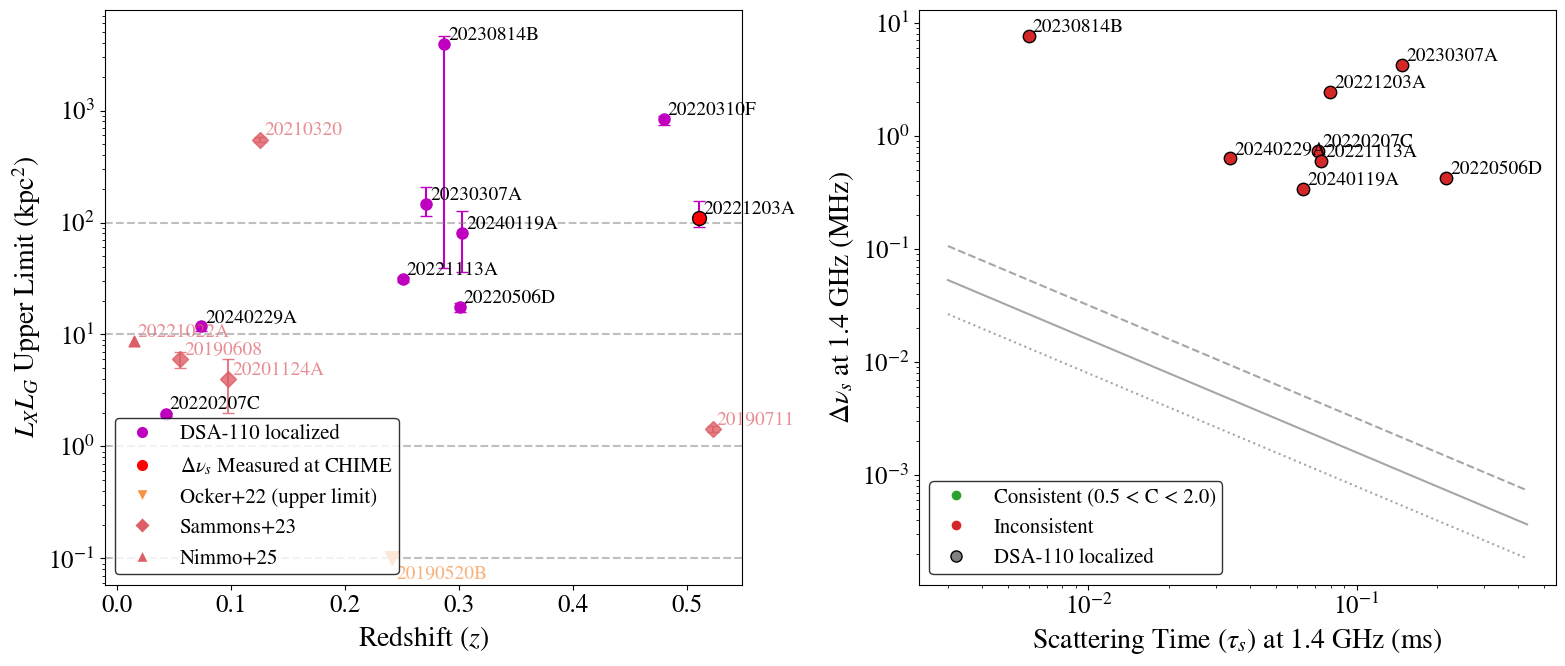


Two-Screen Scattering Analysis Summary:
Total FRBs analyzed: 9

Diagnostic - Non-localized FRBs:

L_X × L_G Upper Limits:
  Median: 80.5 kpc²
  Min: 1.97 kpc²
  Max: 3935 kpc²
  < 1 kpc²: 0
  < 10 kpc²: 1
  < 100 kpc²: 5

Fourier Consistency Check:
  Consistent (0.5 < C < 2.0): 0/8
  Mean C value: 865.10

Individual FRB Results:

FRB 20220207C:
  z = 0.043
  τ(1GHz) = 0.28 ms
  L_X × L_G < 2.0 kpc²
  C = 329.77 ✗

FRB 20220310F:
  z = 0.479
  τ(1GHz) = 0.15 ms
  L_X × L_G < 843.7 kpc²

FRB 20220506D:
  z = 0.300
  τ(1GHz) = 0.83 ms
  L_X × L_G < 17.7 kpc²
  C = 573.90 ✗

FRB 20221113A:
  z = 0.251
  τ(1GHz) = 0.28 ms
  L_X × L_G < 31.1 kpc²
  C = 276.56 ✗

FRB 20221203A:
  z = 0.510
  τ(1GHz) = 0.31 ms
  L_X × L_G < 108.7 kpc²
  C = 1232.09 ✗

FRB 20230307A:
  z = 0.271
  τ(1GHz) = 0.57 ms
  L_X × L_G < 146.7 kpc²
  C = 3951.04 ✗

FRB 20240119A:
  z = 0.302
  τ(1GHz) = 0.24 ms
  L_X × L_G < 80.5 kpc²
  C = 134.95 ✗

FRB 20240229A:
  z = 0.074
  τ(1GHz) = 0.13 ms
  L_X × L_G < 11.8 kpc

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

# --- Physical and Astronomical Constants (SI Units) ---
C_LIGHT = 299792458.0  # Speed of light in m/s
PC_TO_M = 3.0857e16     # Parsecs to meters
KPC_TO_M = PC_TO_M * 1000

# --- Define the Planck 2018 Cosmology ---
cosmo_planck18 = FlatLambdaCDM(H0=67.4, Om0=0.315)

def check_fourier_consistency(tau_s, nu_s, C_factor_range=(0.5, 2.0)):
    """
    Checks if scattering time and scintillation bandwidth are consistent with
    originating from the same screen via the Fourier uncertainty principle.
    """
    calculated_c = 2 * np.pi * tau_s * nu_s
    is_consistent = C_factor_range[0] <= calculated_c <= C_factor_range[1]
    return calculated_c, is_consistent

def estimate_host_screen_distance(redshift, nu_obs_hz, nu_s_mw_hz, tau_s_host_s, d_mw_m, m_mw=1.0):
    """
    Estimates the distance between an FRB and the screen in its host galaxy
    using the Planck 2018 cosmology.
    """
    # Calculate the angular diameter distance to the FRB using the defined cosmology
    d_frb_m = cosmo_planck18.angular_diameter_distance(redshift).to(u.m).value

    # The Pradeep et al. formula:
    numerator = (1 + redshift) * d_frb_m**2 * nu_s_mw_hz
    denominator = 8 * np.pi * nu_obs_hz**2 * m_mw * tau_s_host_s
    
    d_h_d_mw_product_m2 = numerator / denominator
    
    # Solve for the host screen distance
    d_h_frb_m = d_h_d_mw_product_m2 / d_mw_m

    # Convert the final result from meters to parsecs
    d_h_frb_pc = d_h_frb_m / PC_TO_M

    return d_h_frb_pc

# Function to extract gamma values from the text
def extract_gamma_values(text):
    if pd.isna(text) or text == 'None' or text == '' or str(text).strip() == '':
        return [], []
    
    gamma_values = []
    gamma_errors = []
    
    gamma_pattern = r'l_\d_gamma:\s*([\d.]+)\s*±\s*([\d.]+)'
    matches = re.findall(gamma_pattern, str(text))
    
    for match in matches:
        gamma_values.append(float(match[0]))
        gamma_errors.append(float(match[1]))
    
    return gamma_values, gamma_errors

# Function to extract NE2001 prediction
def extract_ne2001(text):
    if pd.isna(text):
        return np.nan
    match = re.search(r'gamma:\s*([\d.]+)', text)
    if match:
        return float(match.group(1))
    return np.nan

# Function to parse tau error strings
def parse_tau_error(tau_err_str):
    """Parse error strings like '(+0.012, -0.002)' """
    if pd.isna(tau_err_str) or tau_err_str == '':
        return np.nan, np.nan
    
    match = re.search(r'\+?([\d.]+).*?-([\d.]+)', str(tau_err_str))
    if match:
        err_plus = float(match.group(1))
        err_minus = float(match.group(2))
        return err_plus, err_minus
    return np.nan, np.nan

# Read the CSV file
df = pd.read_csv('DSA110_CHIMECodetectionBurstProps.csv')

# Process the data for two-screen analysis
frb_names = []
redshifts = []
tau_1ghz_values = []
tau_errors_plus = []
tau_errors_minus = []
ne2001_bw_mhz = []
measured_bw_mhz = []
has_localization = []

for _, row in df.iterrows():
    frb_name = row['TNS Name'].rstrip("'")
    frb_names.append(frb_name)
    redshifts.append(row['Redshift'])
    
    # Extract tau at 1 GHz
    tau_1ghz_values.append(row['tau_1GHz'])
    
    # Parse tau errors
    err_plus, err_minus = parse_tau_error(row['tau_1GHz_err'])
    tau_errors_plus.append(err_plus)
    tau_errors_minus.append(err_minus)
    
    # Extract NE2001 bandwidth
    ne2001_bw_mhz.append(extract_ne2001(row['NE2001: bw_MHz_1.4GHz']))
    
    # Extract measured bandwidths and average
    all_gammas = []
    for col in ['bw_MHz_1.4GHz_component1', 'bw_MHz_1.4GHz_component2']:
        gammas, _ = extract_gamma_values(row[col])
        all_gammas.extend(gammas)
    
    if all_gammas:
        measured_bw_mhz.append(np.mean(all_gammas))
    else:
        measured_bw_mhz.append(np.nan)
    
    # Check localization
    has_localization.append(not pd.isna(row['Localization']) and row['Localization'] != '')

# Convert to arrays
redshifts = np.array(redshifts)
tau_1ghz_values = np.array(tau_1ghz_values)
tau_errors_plus = np.array(tau_errors_plus)
tau_errors_minus = np.array(tau_errors_minus)
ne2001_bw_mhz = np.array(ne2001_bw_mhz)
measured_bw_mhz = np.array(measured_bw_mhz)
has_localization = np.array(has_localization)

# Calculate host screen distances
# Typical MW screen distance: 1 kpc
d_mw_m = 1 * KPC_TO_M
nu_obs_hz = 1.4e9  # 1.4 GHz observation frequency
m_mw = 1.0  # Modulation index

host_screen_distances = []
lx_lg_values = []  # Store L_X * L_G values in kpc^2
fourier_c_values = []
fourier_consistent = []

for i in range(len(frb_names)):
    if not np.isnan(redshifts[i]) and not np.isnan(tau_1ghz_values[i]) and not np.isnan(ne2001_bw_mhz[i]):
        # Convert tau from ms to s
        tau_host_s = tau_1ghz_values[i] * 1e-3
        
        # Convert bandwidth from MHz to Hz
        nu_s_mw_hz = ne2001_bw_mhz[i] * 1e6
        
        # Calculate host screen distance
        d_host = estimate_host_screen_distance(
            redshifts[i], nu_obs_hz, nu_s_mw_hz, tau_host_s, d_mw_m, m_mw
        )
        print(f"d_host: {d_host} kpc for FRB {frb_names[i]} at z={redshifts[i]}")
        host_screen_distances.append(d_host)
        
        # Calculate L_X * L_G (assuming L_G = 1 kpc for the formula, but we'll display the product)
        # The formula gives us L_X when L_G = 1 kpc, so L_X * L_G in kpc^2 is just d_host/1000
        lx_lg = d_host / 1000  # Convert pc to kpc
        lx_lg_values.append(lx_lg)
        
        # Check Fourier consistency
        if not np.isnan(measured_bw_mhz[i]):
            # Scale tau from 1 GHz to 1.4 GHz for consistency
            tau_host_1p4_ghz_s = tau_host_s * (1.4/1.0)**(-4)
            c_val, is_consistent = check_fourier_consistency(
                tau_host_1p4_ghz_s, measured_bw_mhz[i] * 1e6
            )
            fourier_c_values.append(c_val)
            fourier_consistent.append(is_consistent)
        else:
            fourier_c_values.append(np.nan)
            fourier_consistent.append(False)
    else:
        host_screen_distances.append(np.nan)
        lx_lg_values.append(np.nan)
        fourier_c_values.append(np.nan)
        fourier_consistent.append(False)

host_screen_distances = np.array(host_screen_distances)
lx_lg_values = np.array(lx_lg_values)
fourier_c_values = np.array(fourier_c_values)
fourier_consistent = np.array(fourier_consistent)


# Literature values
stella_frbs = ['FRB 20190520B']
stella_zs = [0.241]
stella_lxlg = [0.1]  # LESS THAN kpc^2
mawson_frbs = ['FRB 20190608', 'FRB 20190711', 'FRB 20210320', 'FRB 20201124A']
mawson_lxlg = [6, 1.43, 550, 4]  # kpc^2
mawson_lxlg_err = [1, 0.08, 30, 2]
mawson_zs = [0.056, 0.522, 0.126, 0.098]
kenzie_frbs = ['FRB 20221022A']
kenzie_zs = [0.0149]
kenzie_lxlg = [8.8]  # kpc^2

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# --- Subplot 1: Host Screen Distance vs Redshift ---
valid_mask = ~np.isnan(lx_lg_values) & ~np.isnan(redshifts)

colors = plt.get_cmap('plasma')(np.linspace(0.1, 0.9, 6))

# Plot data points
for i in range(len(frb_names)):
    if valid_mask[i]:
        color = '#1f77b4' if has_localization[i] else '#ff7f0e'
        marker = 'o' if has_localization[i] else 's'
        
        # Calculate error bars for L_X * L_G based on tau errors
        if not np.isnan(tau_errors_plus[i]) and not np.isnan(tau_errors_minus[i]):
            print(f"Processing FRB {frb_names[i]}: tau_1GHz = {tau_1ghz_values[i]}, "
                  f"tau_errors_plus = {tau_errors_plus[i]}, tau_errors_minus = {tau_errors_minus[i]}")
            # L_X * L_G scales as 1/tau, so relative error is the same
            d_err_plus = lx_lg_values[i] * (tau_errors_minus[i] / tau_1ghz_values[i])
            d_err_minus = lx_lg_values[i] * (tau_errors_plus[i] / tau_1ghz_values[i])
            
            # Ensure error bars don't go below zero
            yerr_lower = min(d_err_minus, lx_lg_values[i] * 0.99)  # Cap at 99% of value
            yerr = [[yerr_lower], [d_err_plus]]
        else:
            yerr = None
            
        ax1.errorbar(redshifts[i], lx_lg_values[i], 
                    yerr=yerr, fmt=marker, color='m', 
                    markersize=8, capsize=4, alpha=1, label='_nolegend_')
        
        # Add labels
        ax1.annotate(frb_names[i].replace('FRB ', ''), 
                    (redshifts[i], lx_lg_values[i]),
                    xytext=(3, 3), textcoords='offset points',
                    fontsize=14, alpha=1)

chime_scint_idx = [4, 6, 7, 9]
for i in chime_scint_idx:
    d_err_plus = lx_lg_values[i] * (tau_errors_minus[i] / tau_1ghz_values[i])
    d_err_minus = lx_lg_values[i] * (tau_errors_plus[i] / tau_1ghz_values[i])
    print(f"Processing CHIME FRB {frb_names[i]}: tau_1GHz = {tau_1ghz_values[i]}, "
          f"tau_errors_plus = {tau_errors_plus[i]}, tau_errors_minus = {tau_errors_minus[i]}", f"lx_lg = {lx_lg_values[i]}")
    print(d_err_plus, d_err_minus)

    # Ensure error bars don't go below zero
    yerr_lower = min(d_err_minus, lx_lg_values[i] * 0.99)
    ax1.scatter(redshifts[i], lx_lg_values[i], marker='o', 
                s=100, edgecolors='black', facecolors='red',
                label='$\\Delta\\nu_{s}$ Measured at CHIME', zorder=5)

# Add literature values
# Stella et al. - upper limit
ax1.scatter(stella_zs[0], stella_lxlg[0], marker='v', color=colors[-2], s=100, 
           label='Ocker+22 (upper limit)', zorder=5)
ax1.annotate(stella_frbs[0].replace('FRB ', ''), 
            (stella_zs[0], stella_lxlg[0]),
            xytext=(3, -15), textcoords='offset points',
            fontsize=14, alpha=0.7, color=colors[-2])

# Mawson et al.
ax1.errorbar(mawson_zs, mawson_lxlg, yerr=mawson_lxlg_err, 
            fmt='D', color=colors[3], markersize=8, capsize=4, 
            alpha=0.8, label='Sammons+23')
for i, name in enumerate(mawson_frbs):
    ax1.annotate(name.replace('FRB ', ''), 
                (mawson_zs[i], mawson_lxlg[i]),
                xytext=(3, 3), textcoords='offset points',
                fontsize=14, alpha=0.7, color=colors[3])

# Kenzie et al.
ax1.scatter(kenzie_zs, kenzie_lxlg, marker='^', color=colors[-3], s=60, 
           label='Nimmo+25', zorder=5)
ax1.annotate(kenzie_frbs[0].replace('FRB ', ''), 
            (kenzie_zs[0], kenzie_lxlg[0]),
            xytext=(3, 3), textcoords='offset points',
            fontsize=14, alpha=0.7, color=colors[-3])

ax1.set_xlabel('Redshift ($z$)', fontsize=20)
ax1.set_ylabel('$L_X L_G$ Upper Limit (kpc$^2$)', fontsize=20)
#ax1.set_title('Two-Screen Scattering: Host Screen Distance Constraints', fontsize=22)
ax1.set_yscale('log')
#ax1.set_ylim(0.01, 10000)
#ax1.grid(True, alpha=0.3)

# Add reference lines for typical distances
ax1.axhline(y=0.1, color='gray', linestyle='--', alpha=0.5)
ax1.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax1.axhline(y=10, color='gray', linestyle='--', alpha=0.5)
ax1.axhline(y=100, color='gray', linestyle='--', alpha=0.5)

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='m', 
           markersize=8, label='DSA-110 localized', markeredgecolor='none'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
           markersize=8, label='$\\Delta\\nu_{s}$ Measured at CHIME', markeredgecolor='none'),
    Line2D([0], [0], marker='v', color='w', markerfacecolor=colors[-2], 
           markersize=8, label='Ocker+22 (upper limit)'),
    Line2D([0], [0], marker='D', color='w', markerfacecolor=colors[3], 
           markersize=8, label='Sammons+23'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor=colors[-3], 
           markersize=8, label='Nimmo+25'),
]
ax1.legend(loc='lower left', frameon=True,          # draw the legend patch
        handles=legend_elements,
        fancybox=True,         # use a FancyBboxPatch (i.e. rounded corners)
        framealpha=0.8,        # overall opacity of the legend background
        facecolor='white',     # background color
        edgecolor='black',     # border color
        borderpad=0.3,
        fontsize='small')

# --- Subplot 2: Fourier Consistency Check ---
valid_fourier = ~np.isnan(fourier_c_values)

# Scale tau from 1 GHz to 1.4 GHz for consistency check
# tau scales as nu^(-4) for Kolmogorov turbulence
tau_at_1p4_ghz = tau_1ghz_values * (1.4/1.0)**(-4)

for i in range(len(frb_names)):
    if valid_fourier[i]:
        color = '#2ca02c' if fourier_consistent[i] else '#d62728'
        marker = 'o' if has_localization[i] else 's'
        
        ax2.scatter(tau_at_1p4_ghz[i], measured_bw_mhz[i], 
                   c=color, marker=marker, s=80, alpha=1, edgecolors='black')
        
        # Add labels
        ax2.annotate(frb_names[i].replace('FRB ', ''), 
                    (tau_at_1p4_ghz[i], measured_bw_mhz[i]),
                    xytext=(3, 3), textcoords='offset points',
                    fontsize=14, alpha=1)

# Add theoretical lines for C = 0.5, 1.0, 2.0
# Extend range to cover all data points
tau_min = np.nanmin(tau_at_1p4_ghz[tau_at_1p4_ghz > 0]) * 0.5
tau_max = np.nanmax(tau_at_1p4_ghz) * 2
tau_range = np.logspace(np.log10(tau_min), np.log10(tau_max), 100)
for c_val, label, style in [(0.5, 'C = 0.5', ':'), (1.0, 'C = 1.0', '-'), (2.0, 'C = 2.0', '--')]:
    bw_theory = c_val / (2 * np.pi * tau_range * 1e-3) / 1e6  # Convert to MHz
    ax2.plot(tau_range, bw_theory, style, color='gray', alpha=0.7, label=label)

ax2.set_xlabel('Scattering Time ($\\tau_s$) at 1.4 GHz (ms)', fontsize=20)
ax2.set_ylabel('$\\Delta\\nu_s$ at 1.4 GHz (MHz)', fontsize=20)
#ax2.set_title('Fourier Consistency: $2\\pi\\tau_s\\Delta\\nu_s = C$', fontsize=22)
ax2.set_xscale('log')
ax2.set_yscale('log')
#ax2.grid(True, alpha=0.3)
#ax2.legend(loc='upper right')

# Add color legend for consistency
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ca02c', 
           markersize=8, label='Consistent (0.5 < C < 2.0)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#d62728', 
           markersize=8, label='Inconsistent'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=8, label='DSA-110 localized', markeredgecolor='black'),
]
ax2.legend(loc='lower left', frameon=True,          # draw the legend patch
        handles=legend_elements,
        fancybox=True,         # use a FancyBboxPatch (i.e. rounded corners)
        framealpha=0.8,        # overall opacity of the legend background
        facecolor='white',     # background color
        edgecolor='black',     # border color
        borderpad=0.3,
        fontsize='small')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nTwo-Screen Scattering Analysis Summary:")
print("="*50)
print(f"Total FRBs analyzed: {np.sum(~np.isnan(lx_lg_values))}")

# Diagnostic: Check non-localized FRBs
print("\nDiagnostic - Non-localized FRBs:")
for i in range(len(frb_names)):
    if not has_localization[i]:
        print(f"{frb_names[i]}: z={redshifts[i]}, τ={tau_1ghz_values[i]}, L_X×L_G={lx_lg_values[i]}")

print(f"\nL_X × L_G Upper Limits:")
print(f"  Median: {np.nanmedian(lx_lg_values):.1f} kpc²")
print(f"  Min: {np.nanmin(lx_lg_values):.2f} kpc²")
print(f"  Max: {np.nanmax(lx_lg_values):.0f} kpc²")
print(f"  < 1 kpc²: {np.sum(lx_lg_values < 1)}")
print(f"  < 10 kpc²: {np.sum(lx_lg_values < 10)}")
print(f"  < 100 kpc²: {np.sum(lx_lg_values < 100)}")

print(f"\nFourier Consistency Check:")
print(f"  Consistent (0.5 < C < 2.0): {np.sum(fourier_consistent)}/{np.sum(valid_fourier)}")
print(f"  Mean C value: {np.nanmean(fourier_c_values):.2f}")

print("\nIndividual FRB Results:")
for i in range(len(frb_names)):
    if not np.isnan(lx_lg_values[i]):
        print(f"\n{frb_names[i]}:")
        print(f"  z = {redshifts[i]:.3f}")
        print(f"  τ(1GHz) = {tau_1ghz_values[i]:.2f} ms")
        print(f"  L_X × L_G < {lx_lg_values[i]:.1f} kpc²")
        if not np.isnan(fourier_c_values[i]):
            print(f"  C = {fourier_c_values[i]:.2f} {'✓' if fourier_consistent[i] else '✗'}")

print("\nLiterature Comparison:")
print(f"  Stella+22 (20190520B): < {stella_lxlg[0]} kpc² at z={stella_zs[0]}")
print(f"  Sammons+23: {len(mawson_frbs)} FRBs, median = {np.median(mawson_lxlg):.1f} kpc²")
print(f"  Nimmo+24 (20221022A): {kenzie_lxlg[0]} kpc² at z={kenzie_zs[0]}")

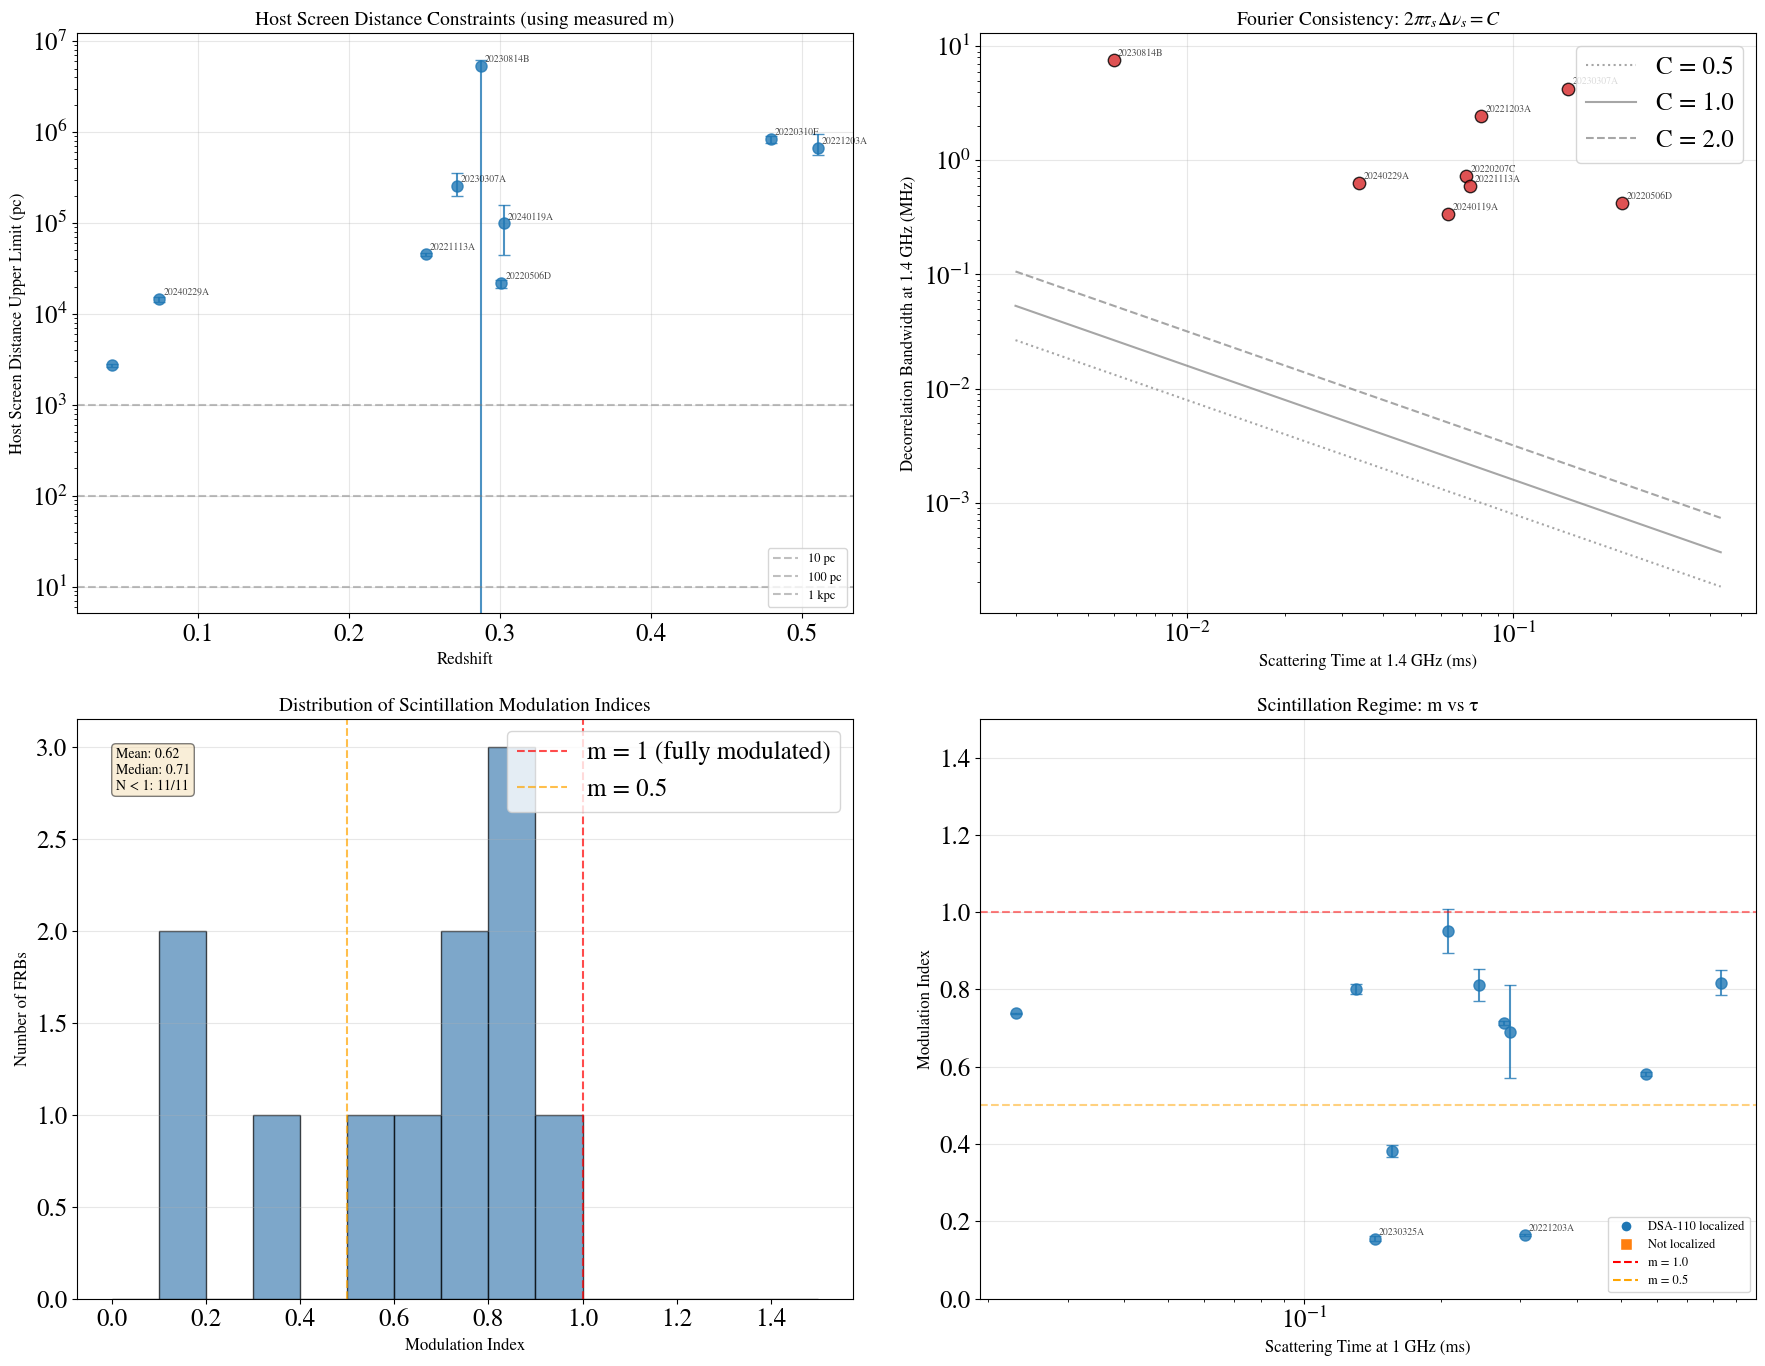


Enhanced Two-Screen Scattering Analysis Summary:
Total FRBs analyzed: 9

Modulation Index Statistics:
  Mean: 0.619
  Median: 0.713
  Range: 0.155 - 0.952
  Fully modulated (m > 0.9): 1
  Partially resolved (m < 0.5): 3

Host Screen Distance Upper Limits (using measured m):
  Median: 99195.5 pc
  Min: 2756.6 pc
  Max: 5329675.4 pc
  < 100 pc: 0
  < 1 kpc: 0

Fourier Consistency Check:
  Consistent (0.5 < C < 2.0): 0/8
  Mean C value: 865.10

Individual FRB Results:
------------------------------------------------------------
FRB             z      τ(1GHz)  m      d_host     C      Consistent
------------------------------------------------------------
20220207C       0.043  0.28     0.713  2756.6     329.77 ✗         
20220310F       0.479  0.15     N/A    843723.1   N/A    N/A       
20220506D       0.300  0.83     0.817  21622.6    573.90 ✗         
20221113A       0.251  0.28     0.691  45081.2    276.56 ✗         
20221203A       0.510  0.31     0.165  659620.5   1232.09 ✗        

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

# --- Physical and Astronomical Constants (SI Units) ---
C_LIGHT = 299792458.0  # Speed of light in m/s
PC_TO_M = 3.0857e16     # Parsecs to meters
KPC_TO_M = PC_TO_M * 1000

# --- Define the Planck 2018 Cosmology ---
cosmo_planck18 = FlatLambdaCDM(H0=67.4, Om0=0.315)

def check_fourier_consistency(tau_s, nu_s, C_factor_range=(0.5, 2.0)):
    """
    Checks if scattering time and scintillation bandwidth are consistent with
    originating from the same screen via the Fourier uncertainty principle.
    """
    calculated_c = 2 * np.pi * tau_s * nu_s
    is_consistent = C_factor_range[0] <= calculated_c <= C_factor_range[1]
    return calculated_c, is_consistent

def estimate_host_screen_distance(redshift, nu_obs_hz, nu_s_mw_hz, tau_s_host_s, d_mw_m, m_mw=1.0):
    """
    Estimates the distance between an FRB and the screen in its host galaxy
    using the Planck 2018 cosmology.
    """
    # Calculate the angular diameter distance to the FRB using the defined cosmology
    d_frb_m = cosmo_planck18.angular_diameter_distance(redshift).to(u.m).value

    # The Pradeep et al. formula:
    numerator = (1 + redshift) * d_frb_m**2 * nu_s_mw_hz
    denominator = 8 * np.pi * nu_obs_hz**2 * m_mw * tau_s_host_s
    
    d_h_d_mw_product_m2 = numerator / denominator
    
    # Solve for the host screen distance
    d_h_frb_m = d_h_d_mw_product_m2 / d_mw_m

    # Convert the final result from meters to parsecs
    d_h_frb_pc = d_h_frb_m / PC_TO_M

    return d_h_frb_pc

# Enhanced function to extract both gamma and modulation index values
def extract_gamma_and_m_values(text):
    if pd.isna(text) or text == 'None' or text == '' or str(text).strip() == '':
        return [], [], [], []
    
    gamma_values = []
    gamma_errors = []
    m_values = []
    m_errors = []
    
    # Find all gamma values with their errors
    gamma_pattern = r'l_\d_gamma:\s*([\d.]+)\s*±\s*([\d.]+)'
    gamma_matches = re.findall(gamma_pattern, str(text))
    
    # Find all modulation index values with their errors
    m_pattern = r'l_\d_m:\s*([\d.]+)\s*±\s*([\d.]+)'
    m_matches = re.findall(m_pattern, str(text))
    
    for match in gamma_matches:
        gamma_values.append(float(match[0]))
        gamma_errors.append(float(match[1]))
    
    for match in m_matches:
        m_values.append(float(match[0]))
        m_errors.append(float(match[1]))
    
    return gamma_values, gamma_errors, m_values, m_errors

# Function to extract NE2001 prediction
def extract_ne2001(text):
    if pd.isna(text):
        return np.nan
    match = re.search(r'gamma:\s*([\d.]+)', text)
    if match:
        return float(match.group(1))
    return np.nan

# Function to parse tau error strings
def parse_tau_error(tau_err_str):
    """Parse error strings like '(+0.012, -0.002)' """
    if pd.isna(tau_err_str) or tau_err_str == '':
        return np.nan, np.nan
    
    match = re.search(r'\+?([\d.]+).*?-([\d.]+)', str(tau_err_str))
    if match:
        err_plus = float(match.group(1))
        err_minus = float(match.group(2))
        return err_plus, err_minus
    return np.nan, np.nan

# Read the CSV file
df = pd.read_csv('DSA110_CHIMECodetectionBurstProps.csv')

# Process the data for enhanced two-screen analysis
frb_names = []
redshifts = []
tau_1ghz_values = []
tau_errors_plus = []
tau_errors_minus = []
ne2001_bw_mhz = []
measured_bw_mhz = []
measured_m_values = []
measured_m_errors = []
has_localization = []

for _, row in df.iterrows():
    frb_name = row['TNS Name'].rstrip("'")
    frb_names.append(frb_name)
    redshifts.append(row['Redshift'])
    
    # Extract tau at 1 GHz
    tau_1ghz_values.append(row['tau_1GHz'])
    
    # Parse tau errors
    err_plus, err_minus = parse_tau_error(row['tau_1GHz_err'])
    tau_errors_plus.append(err_plus)
    tau_errors_minus.append(err_minus)
    
    # Extract NE2001 bandwidth
    ne2001_bw_mhz.append(extract_ne2001(row['NE2001: bw_MHz_1.4GHz']))
    
    # Extract measured bandwidths and modulation indices
    all_gammas = []
    all_m_values = []
    all_m_errors = []
    
    for col in ['bw_MHz_1.4GHz_component1', 'bw_MHz_1.4GHz_component2']:
        gammas, g_errors, m_vals, m_errs = extract_gamma_and_m_values(row[col])
        all_gammas.extend(gammas)
        all_m_values.extend(m_vals)
        all_m_errors.extend(m_errs)
    
    if all_gammas:
        measured_bw_mhz.append(np.mean(all_gammas))
    else:
        measured_bw_mhz.append(np.nan)
    
    if all_m_values:
        # Weight average by inverse variance if we have errors
        if all_m_errors and not any(e == 0 for e in all_m_errors):
            weights = [1/e**2 for e in all_m_errors]
            weighted_avg = np.sum([m*w for m,w in zip(all_m_values, weights)]) / np.sum(weights)
            weighted_err = 1 / np.sqrt(np.sum(weights))
            measured_m_values.append(weighted_avg)
            measured_m_errors.append(weighted_err)
        else:
            measured_m_values.append(np.mean(all_m_values))
            measured_m_errors.append(np.mean(all_m_errors) if all_m_errors else np.nan)
    else:
        measured_m_values.append(np.nan)
        measured_m_errors.append(np.nan)
    
    # Check localization
    has_localization.append(not pd.isna(row['Localization']) and row['Localization'] != '')

# Convert to arrays
redshifts = np.array(redshifts)
tau_1ghz_values = np.array(tau_1ghz_values)
tau_errors_plus = np.array(tau_errors_plus)
tau_errors_minus = np.array(tau_errors_minus)
ne2001_bw_mhz = np.array(ne2001_bw_mhz)
measured_bw_mhz = np.array(measured_bw_mhz)
measured_m_values = np.array(measured_m_values)
measured_m_errors = np.array(measured_m_errors)
has_localization = np.array(has_localization)

# Calculate host screen distances using measured modulation indices
d_mw_m = 1 * KPC_TO_M
nu_obs_hz = 1.4e9  # 1.4 GHz observation frequency

host_screen_distances = []
fourier_c_values = []
fourier_consistent = []

for i in range(len(frb_names)):
    if not np.isnan(redshifts[i]) and not np.isnan(tau_1ghz_values[i]) and not np.isnan(ne2001_bw_mhz[i]):
        # Convert tau from ms to s
        tau_host_s = tau_1ghz_values[i] * 1e-3
        
        # Convert bandwidth from MHz to Hz
        nu_s_mw_hz = ne2001_bw_mhz[i] * 1e6
        
        # Use measured modulation index if available, otherwise default to 1.0
        m_mw_use = measured_m_values[i] if not np.isnan(measured_m_values[i]) else 1.0
        
        # Calculate host screen distance
        d_host = estimate_host_screen_distance(
            redshifts[i], nu_obs_hz, nu_s_mw_hz, tau_host_s, d_mw_m, m_mw_use
        )
        host_screen_distances.append(d_host)
        
        # Check Fourier consistency
        if not np.isnan(measured_bw_mhz[i]):
            # Scale tau from 1 GHz to 1.4 GHz for consistency
            tau_host_1p4_ghz_s = tau_host_s * (1.4/1.0)**(-4)
            c_val, is_consistent = check_fourier_consistency(
                tau_host_1p4_ghz_s, measured_bw_mhz[i] * 1e6
            )
            fourier_c_values.append(c_val)
            fourier_consistent.append(is_consistent)
        else:
            fourier_c_values.append(np.nan)
            fourier_consistent.append(False)
    else:
        host_screen_distances.append(np.nan)
        fourier_c_values.append(np.nan)
        fourier_consistent.append(False)

host_screen_distances = np.array(host_screen_distances)
fourier_c_values = np.array(fourier_c_values)
fourier_consistent = np.array(fourier_consistent)

# Create the figure with four subplots
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# --- Subplot 1: Host Screen Distance vs Redshift ---
valid_mask = ~np.isnan(host_screen_distances) & ~np.isnan(redshifts)

# Plot data points
for i in range(len(frb_names)):
    if valid_mask[i]:
        color = '#1f77b4' if has_localization[i] else '#ff7f0e'
        marker = 'o' if has_localization[i] else 's'
        
        # Calculate error bars for screen distance based on tau errors
        if not np.isnan(tau_errors_plus[i]) and not np.isnan(tau_errors_minus[i]):
            # Screen distance scales as 1/tau, so relative error is the same
            d_err_plus = host_screen_distances[i] * (tau_errors_minus[i] / tau_1ghz_values[i])
            d_err_minus = host_screen_distances[i] * (tau_errors_plus[i] / tau_1ghz_values[i])
            yerr = [[d_err_minus], [d_err_plus]]
        else:
            yerr = None
            
        ax1.errorbar(redshifts[i], host_screen_distances[i], 
                    yerr=yerr, fmt=marker, color=color, 
                    markersize=8, capsize=4, alpha=0.8)
        
        # Add labels for extreme cases
        if host_screen_distances[i] < 50 or host_screen_distances[i] > 5000:
            ax1.annotate(frb_names[i].replace('FRB ', ''), 
                        (redshifts[i], host_screen_distances[i]),
                        xytext=(3, 3), textcoords='offset points',
                        fontsize=7, alpha=0.7)

ax1.set_xlabel('Redshift', fontsize=12)
ax1.set_ylabel('Host Screen Distance Upper Limit (pc)', fontsize=12)
ax1.set_title('Host Screen Distance Constraints (using measured m)', fontsize=14)
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# Add reference lines for typical distances
ax1.axhline(y=10, color='gray', linestyle='--', alpha=0.5, label='10 pc')
ax1.axhline(y=100, color='gray', linestyle='--', alpha=0.5, label='100 pc')
ax1.axhline(y=1000, color='gray', linestyle='--', alpha=0.5, label='1 kpc')
ax1.legend(loc='lower right', fontsize=9)

# --- Subplot 2: Fourier Consistency Check ---
valid_fourier = ~np.isnan(fourier_c_values)

# Scale tau from 1 GHz to 1.4 GHz for consistency check
tau_at_1p4_ghz = tau_1ghz_values * (1.4/1.0)**(-4)

for i in range(len(frb_names)):
    if valid_fourier[i]:
        color = '#2ca02c' if fourier_consistent[i] else '#d62728'
        marker = 'o' if has_localization[i] else 's'
        
        ax2.scatter(tau_at_1p4_ghz[i], measured_bw_mhz[i], 
                   c=color, marker=marker, s=80, alpha=0.8, edgecolors='black')
        
        # Add labels
        ax2.annotate(frb_names[i].replace('FRB ', ''), 
                    (tau_at_1p4_ghz[i], measured_bw_mhz[i]),
                    xytext=(3, 3), textcoords='offset points',
                    fontsize=7, alpha=0.7)

# Add theoretical lines for C = 0.5, 1.0, 2.0
tau_min = np.nanmin(tau_at_1p4_ghz[tau_at_1p4_ghz > 0]) * 0.5
tau_max = np.nanmax(tau_at_1p4_ghz) * 2
tau_range = np.logspace(np.log10(tau_min), np.log10(tau_max), 100)
for c_val, label, style in [(0.5, 'C = 0.5', ':'), (1.0, 'C = 1.0', '-'), (2.0, 'C = 2.0', '--')]:
    bw_theory = c_val / (2 * np.pi * tau_range * 1e-3) / 1e6  # Convert to MHz
    ax2.plot(tau_range, bw_theory, style, color='gray', alpha=0.7, label=label)

ax2.set_xlabel('Scattering Time at 1.4 GHz (ms)', fontsize=12)
ax2.set_ylabel('Decorrelation Bandwidth at 1.4 GHz (MHz)', fontsize=12)
ax2.set_title('Fourier Consistency: $2\\pi\\tau_s\\Delta\\nu_s = C$', fontsize=14)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right')

# --- Subplot 3: Modulation Index Distribution ---
valid_m = ~np.isnan(measured_m_values)

# Create histogram
m_bins = np.linspace(0, 1.5, 16)
ax3.hist(measured_m_values[valid_m], bins=m_bins, alpha=0.7, color='steelblue', edgecolor='black')

# Add reference lines
ax3.axvline(x=1.0, color='red', linestyle='--', alpha=0.7, label='m = 1 (fully modulated)')
ax3.axvline(x=0.5, color='orange', linestyle='--', alpha=0.7, label='m = 0.5')

ax3.set_xlabel('Modulation Index', fontsize=12)
ax3.set_ylabel('Number of FRBs', fontsize=12)
ax3.set_title('Distribution of Scintillation Modulation Indices', fontsize=14)
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3, axis='y')

# Add text box with statistics
textstr = f'Mean: {np.nanmean(measured_m_values):.2f}\n'
textstr += f'Median: {np.nanmedian(measured_m_values):.2f}\n'
textstr += f'N < 1: {np.sum(measured_m_values[valid_m] < 1)}/{np.sum(valid_m)}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax3.text(0.05, 0.95, textstr, transform=ax3.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# --- Subplot 4: Modulation Index vs Scattering Time ---
for i in range(len(frb_names)):
    if not np.isnan(measured_m_values[i]) and not np.isnan(tau_1ghz_values[i]):
        color = '#1f77b4' if has_localization[i] else '#ff7f0e'
        marker = 'o' if has_localization[i] else 's'
        
        ax4.errorbar(tau_1ghz_values[i], measured_m_values[i], 
                    yerr=measured_m_errors[i] if not np.isnan(measured_m_errors[i]) else None,
                    fmt=marker, color=color, markersize=8, capsize=4, alpha=0.8)
        
        # Label FRBs with extreme modulation indices
        if measured_m_values[i] < 0.3 or measured_m_values[i] > 1.2:
            ax4.annotate(frb_names[i].replace('FRB ', ''), 
                        (tau_1ghz_values[i], measured_m_values[i]),
                        xytext=(3, 3), textcoords='offset points',
                        fontsize=7, alpha=0.7)

ax4.set_xlabel('Scattering Time at 1 GHz (ms)', fontsize=12)
ax4.set_ylabel('Modulation Index', fontsize=12)
ax4.set_title('Scintillation Regime: m vs τ', fontsize=14)
ax4.set_xscale('log')
ax4.axhline(y=1.0, color='red', linestyle='--', alpha=0.5)
ax4.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5)
ax4.set_ylim(0, 1.5)
ax4.grid(True, alpha=0.3)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#1f77b4', 
           markersize=8, label='DSA-110 localized'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#ff7f0e', 
           markersize=8, label='Not localized'),
    Line2D([0], [0], color='red', linestyle='--', label='m = 1.0'),
    Line2D([0], [0], color='orange', linestyle='--', label='m = 0.5')
]
ax4.legend(handles=legend_elements, loc='lower right', fontsize=9)

plt.tight_layout()
plt.show()

# Print comprehensive summary statistics
print("\nEnhanced Two-Screen Scattering Analysis Summary:")
print("="*60)
print(f"Total FRBs analyzed: {np.sum(valid_mask)}")

print(f"\nModulation Index Statistics:")
print(f"  Mean: {np.nanmean(measured_m_values):.3f}")
print(f"  Median: {np.nanmedian(measured_m_values):.3f}")
print(f"  Range: {np.nanmin(measured_m_values):.3f} - {np.nanmax(measured_m_values):.3f}")
print(f"  Fully modulated (m > 0.9): {np.sum(measured_m_values > 0.9)}")
print(f"  Partially resolved (m < 0.5): {np.sum(measured_m_values < 0.5)}")

print(f"\nHost Screen Distance Upper Limits (using measured m):")
print(f"  Median: {np.nanmedian(host_screen_distances):.1f} pc")
print(f"  Min: {np.nanmin(host_screen_distances):.1f} pc")
print(f"  Max: {np.nanmax(host_screen_distances):.1f} pc")
print(f"  < 100 pc: {np.sum(host_screen_distances < 100)}")
print(f"  < 1 kpc: {np.sum(host_screen_distances < 1000)}")

print(f"\nFourier Consistency Check:")
print(f"  Consistent (0.5 < C < 2.0): {np.sum(fourier_consistent)}/{np.sum(valid_fourier)}")
print(f"  Mean C value: {np.nanmean(fourier_c_values):.2f}")

print("\nIndividual FRB Results:")
print("-"*60)
print(f"{'FRB':<15} {'z':<6} {'τ(1GHz)':<8} {'m':<6} {'d_host':<10} {'C':<6} {'Consistent':<10}")
print("-"*60)

for i in range(len(frb_names)):
    if not np.isnan(host_screen_distances[i]):
        c_str = f"{fourier_c_values[i]:.2f}" if not np.isnan(fourier_c_values[i]) else "N/A"
        consistent_str = "✓" if fourier_consistent[i] else "✗" if not np.isnan(fourier_c_values[i]) else "N/A"
        m_str = f"{measured_m_values[i]:.3f}" if not np.isnan(measured_m_values[i]) else "N/A"
        
        print(f"{frb_names[i].replace('FRB ', ''):<15} {redshifts[i]:<6.3f} "
              f"{tau_1ghz_values[i]:<8.2f} {m_str:<6} "
              f"{host_screen_distances[i]:<10.1f} {c_str:<6} {consistent_str:<10}")

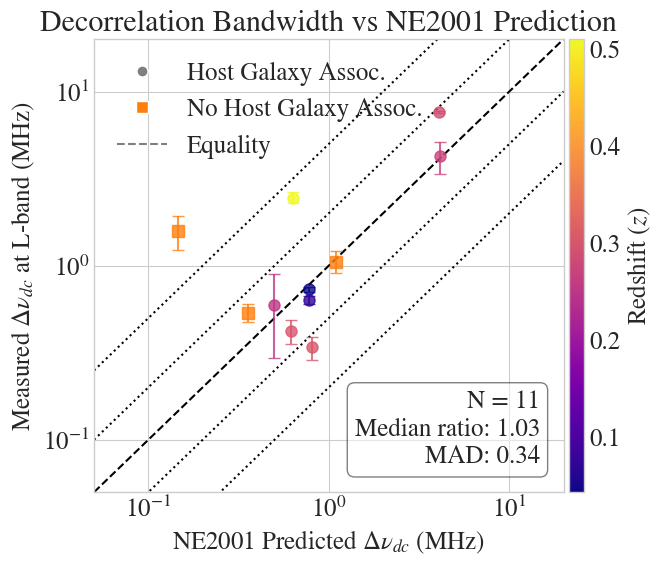

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from adjustText import adjust_text
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.lines import Line2D

# --- Plotting Setup ---
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['STIXGeneral', 'DejaVu Serif'],
    'mathtext.fontset': 'stix',
    'font.size': 18,
    'axes.unicode_minus': True,
})

# --- Data Loading and Parsing ---

# Use the filename from your script
df = pd.read_csv('DSA110_CHIMECodetectionBurstProps.csv')

# Function to extract gamma values from the text
def extract_gamma_values(text):
    if pd.isna(text) or text == 'None' or text == '' or str(text).strip() == '':
        return [], []  # Return empty lists for both values and errors
    
    gamma_values = []
    gamma_errors = []
    
    # Find all gamma values with their errors
    gamma_pattern = r'l_\d_gamma:\s*([\d.]+)\s*±\s*([\d.]+)'
    matches = re.findall(gamma_pattern, str(text))
    
    for match in matches:
        gamma_values.append(float(match[0]))
        gamma_errors.append(float(match[1]))
    
    return gamma_values, gamma_errors

# Function to extract NE2001 prediction
def extract_ne2001(text):
    if pd.isna(text):
        return np.nan
    match = re.search(r'gamma:\s*([\d.]+)', text)
    if match:
        return float(match.group(1))
    return np.nan

# --- Data Processing Loop ---
tns_names = []
measured_gammas = []
measured_gammas_err = []
ne2001_predictions = []
has_localization = []
redshifts = []

for _, row in df.iterrows():
    tns_name = row['TNS Name'].rstrip("'")
    tns_names.append(tns_name)
    
    all_gammas = []
    all_errors = []
    
    for col in ['bw_MHz_1.4GHz_component1', 'bw_MHz_1.4GHz_component2']:
        gammas, errors = extract_gamma_values(row[col])
        all_gammas.extend(gammas)
        all_errors.extend(errors)
    
    if all_gammas:
        measured_gammas.append(np.mean(all_gammas))
        # --- EDITED: Correct error propagation ---
        # Combine errors in quadrature for the error on the mean
        if all_errors:
            error_on_mean = np.sqrt(np.sum(np.array(all_errors)**2)) / len(all_errors)
            measured_gammas_err.append(error_on_mean)
        else:
            measured_gammas_err.append(np.nan)
    else:
        measured_gammas.append(np.nan)
        measured_gammas_err.append(np.nan)
    
    ne2001_predictions.append(extract_ne2001(row['NE2001: bw_MHz_1.4GHz']))
    has_localization.append(not pd.isna(row['Localization']) and row['Localization'] != '')
    redshifts.append(row['Redshift'])

# Convert lists to numpy arrays for easier manipulation
measured_gammas = np.array(measured_gammas)
measured_gammas_err = np.array(measured_gammas_err)
ne2001_predictions = np.array(ne2001_predictions)
has_localization = np.array(has_localization)
redshifts = np.array(redshifts, dtype=float) # Ensure redshift is float

# --- Plotting ---
fig, ax = plt.subplots(figsize=(7, 6))

# Plot limits and equality/factor lines
plot_min, plot_max = 0.05, 20
ax.set_xlim(plot_min, plot_max)
ax.set_ylim(plot_min, plot_max)
x_line = np.logspace(np.log10(plot_min), np.log10(plot_max), 100)
ax.plot(x_line, x_line, 'k--')#, alpha=0.5)
ax.plot(x_line, 2*x_line, 'k:')#, alpha=0.3)
ax.plot(x_line, x_line/2, 'k:')#, alpha=0.3)
ax.plot(x_line, 5*x_line, 'k:')#, alpha=0.15)
ax.plot(x_line, x_line/5, 'k:')#, alpha=0.15)

# --- Redshift Colormap Setup ---
# Create a colormap for localized bursts based on their redshift
valid_redshifts = redshifts[has_localization & ~np.isnan(redshifts)]
if len(valid_redshifts) > 0:
    norm = colors.Normalize(vmin=np.min(valid_redshifts), vmax=np.max(valid_redshifts))
    cmap = cm.plasma
else: # Fallback if no valid redshifts
    norm = colors.Normalize(vmin=0, vmax=1)
    cmap = cm.plasma

# Plot data points and collect text labels
texts = []
for i in range(len(tns_names)):
    if not np.isnan(measured_gammas[i]) and not np.isnan(ne2001_predictions[i]):
        # Determine marker and color based on localization status
        if has_localization[i] and not np.isnan(redshifts[i]):
            marker = 'o'
            point_color = cmap(norm(redshifts[i]))
        else:
            marker = 's'
            point_color = '#ff7f0e' # Orange for non-localized
            
        ax.errorbar(ne2001_predictions[i], measured_gammas[i], 
                   yerr=measured_gammas_err[i], 
                   fmt=marker, color=point_color, 
                   markersize=8, capsize=4, alpha=0.8, ecolor=point_color)
        
        # Add labels to a list for later adjustment
        #short_name = tns_names[i].replace('FRB ', '')
        #texts.append(ax.text(ne2001_predictions[i], measured_gammas[i], short_name)) #, #fontsize=8, alpha=0.9))

# --- Automatic Label Adjustment ---
if texts:
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5, alpha=0.5))

# Axes settings
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('NE2001 Predicted $\Delta\\nu_{dc}$ (MHz)') #, fontsize=14)
ax.set_ylabel('Measured $\Delta\\nu_{dc}$ at L-band (MHz)')#, fontsize=14)
ax.set_title('Decorrelation Bandwidth vs NE2001 Prediction')#, fontsize=16)

# --- Updated Legend and Colorbar ---
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=8, label='Host Galaxy Assoc.'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#ff7f0e', 
           markersize=8, label='No Host Galaxy Assoc.'),
    Line2D([0], [0], color='k', linestyle='--', alpha=0.5, label='Equality'),
]
ax.legend(handles=legend_elements, loc='upper left')#, fontsize=10)

# Add colorbar for redshift
if len(valid_redshifts) > 0:
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, pad=0.01, aspect=30)
    cbar.set_label('Redshift ($z$)') #fontsize=12)

# Statistics Box
valid_mask = ~np.isnan(measured_gammas) & ~np.isnan(ne2001_predictions)
if np.sum(valid_mask) > 0:
    ratios = measured_gammas[valid_mask] / ne2001_predictions[valid_mask]
    median_ratio = np.median(ratios)
    mad_ratio = np.median(np.abs(ratios - median_ratio))
    
    textstr = f'N = {np.sum(valid_mask)}\n'
    textstr += f'Median ratio: {median_ratio:.2f}\n'
    textstr += f'MAD: {mad_ratio:.2f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.95, 0.05, textstr, transform=ax.transAxes, #fontsize=10,
            verticalalignment='bottom', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()


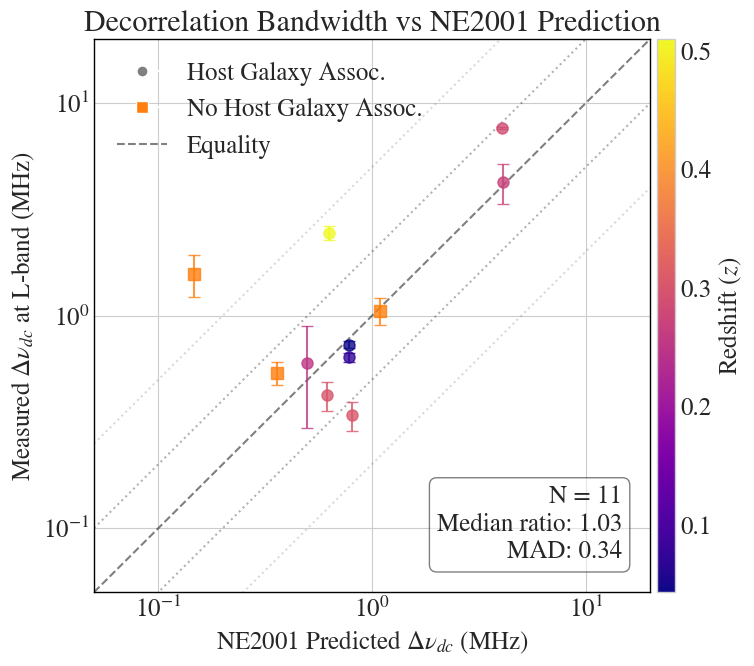

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from adjustText import adjust_text
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.lines import Line2D

# --- Plotting Setup ---
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['STIXGeneral', 'DejaVu Serif'],
    'mathtext.fontset': 'stix',
    'font.size': 18,
    'axes.unicode_minus': True,
})

# --- Data Loading and Parsing ---

# Use the filename from your script
df = pd.read_csv('DSA110_CHIMECodetectionBurstProps.csv')

# Function to extract gamma values from the text
def extract_gamma_values(text):
    if pd.isna(text) or text == 'None' or text == '' or str(text).strip() == '':
        return [], []  # Return empty lists for both values and errors
    
    gamma_values = []
    gamma_errors = []
    
    # Find all gamma values with their errors
    gamma_pattern = r'l_\d_gamma:\s*([\d.]+)\s*±\s*([\d.]+)'
    matches = re.findall(gamma_pattern, str(text))
    
    for match in matches:
        gamma_values.append(float(match[0]))
        gamma_errors.append(float(match[1]))
    
    return gamma_values, gamma_errors

# Function to extract NE2001 prediction
def extract_ne2001(text):
    if pd.isna(text):
        return np.nan
    match = re.search(r'gamma:\s*([\d.]+)', text)
    if match:
        return float(match.group(1))
    return np.nan

# --- Data Processing Loop ---
tns_names = []
measured_gammas = []
measured_gammas_err = []
ne2001_predictions = []
has_localization = []
redshifts = []

for _, row in df.iterrows():
    tns_name = row['TNS Name'].rstrip("'")
    tns_names.append(tns_name)
    
    all_gammas = []
    all_errors = []
    
    for col in ['bw_MHz_1.4GHz_component1', 'bw_MHz_1.4GHz_component2']:
        gammas, errors = extract_gamma_values(row[col])
        all_gammas.extend(gammas)
        all_errors.extend(errors)
    
    if all_gammas:
        measured_gammas.append(np.mean(all_gammas))
        # Combine errors in quadrature for the error on the mean
        if all_errors:
            error_on_mean = np.sqrt(np.sum(np.array(all_errors)**2)) / len(all_errors)
            measured_gammas_err.append(error_on_mean)
        else:
            measured_gammas_err.append(np.nan)
    else:
        measured_gammas.append(np.nan)
        measured_gammas_err.append(np.nan)
    
    ne2001_predictions.append(extract_ne2001(row['NE2001: bw_MHz_1.4GHz']))
    has_localization.append(not pd.isna(row['Localization']) and row['Localization'] != '')
    redshifts.append(row['Redshift'])

# Convert lists to numpy arrays for easier manipulation
measured_gammas = np.array(measured_gammas)
measured_gammas_err = np.array(measured_gammas_err)
ne2001_predictions = np.array(ne2001_predictions)
has_localization = np.array(has_localization)
redshifts = np.array(redshifts, dtype=float) # Ensure redshift is float

# --- Plotting ---
fig, ax = plt.subplots(figsize=(8, 7))

# --- EDITED: Make plot border (spines) solid black ---
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.0)

# Plot limits and equality/factor lines
plot_min, plot_max = 0.05, 20
ax.set_xlim(plot_min, plot_max)
ax.set_ylim(plot_min, plot_max)
x_line = np.logspace(np.log10(plot_min), np.log10(plot_max), 100)
# --- EDITED: Restored alpha values for guide lines ---
ax.plot(x_line, x_line, 'k--', alpha=0.5)
ax.plot(x_line, 2*x_line, 'k:', alpha=0.3)
ax.plot(x_line, x_line/2, 'k:', alpha=0.3)
ax.plot(x_line, 5*x_line, 'k:', alpha=0.15)
ax.plot(x_line, x_line/5, 'k:', alpha=0.15)

# --- Redshift Colormap Setup ---
# Create a colormap for localized bursts based on their redshift
valid_redshifts = redshifts[has_localization & ~np.isnan(redshifts)]
if len(valid_redshifts) > 0:
    norm = colors.Normalize(vmin=np.min(valid_redshifts), vmax=np.max(valid_redshifts))
    cmap = cm.plasma
else: # Fallback if no valid redshifts
    norm = colors.Normalize(vmin=0, vmax=1)
    cmap = cm.plasma

# Plot data points
for i in range(len(tns_names)):
    if not np.isnan(measured_gammas[i]) and not np.isnan(ne2001_predictions[i]):
        # Determine marker and color based on localization status
        if has_localization[i] and not np.isnan(redshifts[i]):
            marker = 'o'
            point_color = cmap(norm(redshifts[i]))
        else:
            marker = 's'
            point_color = '#ff7f0e' # Orange for non-localized
            
        ax.errorbar(ne2001_predictions[i], measured_gammas[i], 
                   yerr=measured_gammas_err[i], 
                   fmt=marker, color=point_color, 
                   markersize=8, capsize=4, alpha=0.8, ecolor=point_color)

# Axes settings
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('NE2001 Predicted $\Delta\\nu_{dc}$ (MHz)')
ax.set_ylabel('Measured $\Delta\\nu_{dc}$ at L-band (MHz)')
ax.set_title('Decorrelation Bandwidth vs NE2001 Prediction')

# --- Updated Legend ---
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=8, label='Host Galaxy Assoc.'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#ff7f0e', 
           markersize=8, label='No Host Galaxy Assoc.'),
    Line2D([0], [0], color='k', linestyle='--', alpha=0.5, label='Equality'),
]
ax.legend(handles=legend_elements, loc='upper left')

# Add colorbar for redshift
if len(valid_redshifts) > 0:
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, pad=0.01, aspect=30)
    cbar.set_label('Redshift ($z$)')

# Statistics Box
valid_mask = ~np.isnan(measured_gammas) & ~np.isnan(ne2001_predictions)
if np.sum(valid_mask) > 0:
    ratios = measured_gammas[valid_mask] / ne2001_predictions[valid_mask]
    median_ratio = np.median(ratios)
    mad_ratio = np.median(np.abs(ratios - median_ratio))
    
    textstr = f'N = {np.sum(valid_mask)}\n'
    textstr += f'Median ratio: {median_ratio:.2f}\n'
    textstr += f'MAD: {mad_ratio:.2f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.95, 0.05, textstr, transform=ax.transAxes,
            verticalalignment='bottom', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()


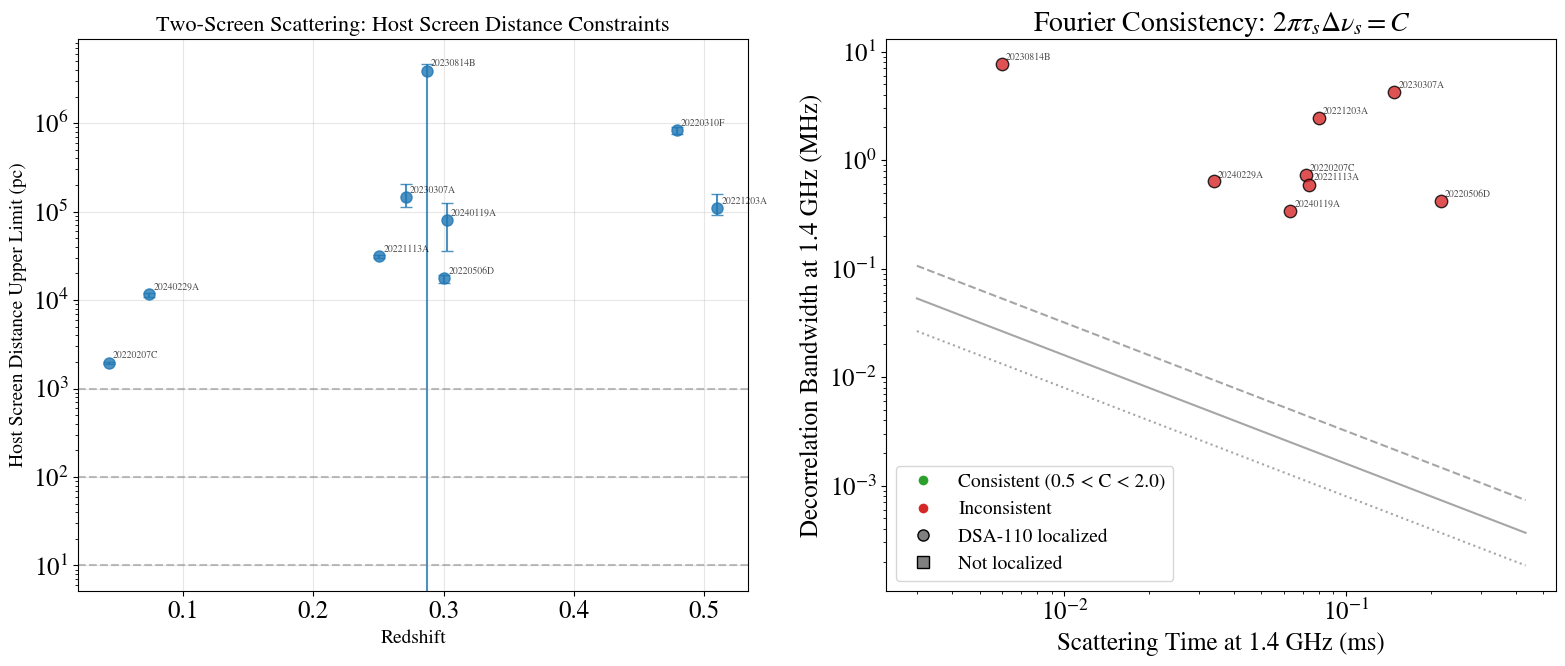


Two-Screen Scattering Analysis Summary:
Total FRBs analyzed: 9

Host Screen Distance Upper Limits:
  Median: 80472.8 pc
  Min: 1966.5 pc
  Max: 3935498.8 pc
  < 100 pc: 0
  < 1 kpc: 0

Fourier Consistency Check:
  Consistent (0.5 < C < 2.0): 0/8
  Mean C value: 865.10

Individual FRB Results:

FRB 20220207C:
  z = 0.043
  τ(1GHz) = 0.28 ms
  d_host < 1966.5 pc
  C = 329.77 ✗

FRB 20220310F:
  z = 0.479
  τ(1GHz) = 0.15 ms
  d_host < 843723.1 pc

FRB 20220506D:
  z = 0.300
  τ(1GHz) = 0.83 ms
  d_host < 17661.2 pc
  C = 573.90 ✗

FRB 20221113A:
  z = 0.251
  τ(1GHz) = 0.28 ms
  d_host < 31137.6 pc
  C = 276.56 ✗

FRB 20221203A:
  z = 0.510
  τ(1GHz) = 0.31 ms
  d_host < 108653.2 pc
  C = 1232.09 ✗

FRB 20230307A:
  z = 0.271
  τ(1GHz) = 0.57 ms
  d_host < 146701.0 pc
  C = 3951.04 ✗

FRB 20240119A:
  z = 0.302
  τ(1GHz) = 0.24 ms
  d_host < 80472.8 pc
  C = 134.95 ✗

FRB 20240229A:
  z = 0.074
  τ(1GHz) = 0.13 ms
  d_host < 11795.0 pc
  C = 135.38 ✗

FRB 20230814B:
  z = 0.287
  τ(1GHz

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['STIXGeneral', 'DejaVu Serif'],
    'mathtext.fontset': 'stix',
    'font.size': 18,
    'axes.unicode_minus': True,
})

# --- Physical and Astronomical Constants (SI Units) ---
C_LIGHT = 299792458.0  # Speed of light in m/s
PC_TO_M = 3.0857e16     # Parsecs to meters
KPC_TO_M = PC_TO_M * 1000

# --- Define the Planck 2018 Cosmology ---
cosmo_planck18 = FlatLambdaCDM(H0=67.4, Om0=0.315)

def check_fourier_consistency(tau_s, nu_s, C_factor_range=(0.5, 2.0)):
    """
    Checks if scattering time and scintillation bandwidth are consistent with
    originating from the same screen via the Fourier uncertainty principle.
    """
    calculated_c = 2 * np.pi * tau_s * nu_s
    is_consistent = C_factor_range[0] <= calculated_c <= C_factor_range[1]
    return calculated_c, is_consistent

def estimate_host_screen_distance(redshift, nu_obs_hz, nu_s_mw_hz, tau_s_host_s, d_mw_m, m_mw=1.0):
    """
    Estimates the distance between an FRB and the screen in its host galaxy
    using the Planck 2018 cosmology.
    """
    # Calculate the angular diameter distance to the FRB using the defined cosmology
    d_frb_m = cosmo_planck18.angular_diameter_distance(redshift).to(u.m).value

    # The Pradeep et al. formula:
    numerator = (1 + redshift) * d_frb_m**2 * nu_s_mw_hz
    denominator = 8 * np.pi * nu_obs_hz**2 * m_mw * tau_s_host_s
    
    d_h_d_mw_product_m2 = numerator / denominator
    
    # Solve for the host screen distance
    d_h_frb_m = d_h_d_mw_product_m2 / d_mw_m

    # Convert the final result from meters to parsecs
    d_h_frb_pc = d_h_frb_m / PC_TO_M

    return d_h_frb_pc

# Function to extract gamma values from the text
def extract_gamma_values(text):
    if pd.isna(text) or text == 'None' or text == '' or str(text).strip() == '':
        return [], []
    
    gamma_values = []
    gamma_errors = []
    
    gamma_pattern = r'l_\d_gamma:\s*([\d.]+)\s*±\s*([\d.]+)'
    matches = re.findall(gamma_pattern, str(text))
    
    for match in matches:
        gamma_values.append(float(match[0]))
        gamma_errors.append(float(match[1]))
    
    return gamma_values, gamma_errors

# Function to extract NE2001 prediction
def extract_ne2001(text):
    if pd.isna(text):
        return np.nan
    match = re.search(r'gamma:\s*([\d.]+)', text)
    if match:
        return float(match.group(1))
    return np.nan

# Function to parse tau error strings
def parse_tau_error(tau_err_str):
    """Parse error strings like '(+0.012, -0.002)' """
    if pd.isna(tau_err_str) or tau_err_str == '':
        return np.nan, np.nan
    
    match = re.search(r'\+?([\d.]+).*?-([\d.]+)', str(tau_err_str))
    if match:
        err_plus = float(match.group(1))
        err_minus = float(match.group(2))
        return err_plus, err_minus
    return np.nan, np.nan

# Read the CSV file
df = pd.read_csv('DSA110_CHIMECodetectionBurstProps.csv')

# Process the data for two-screen analysis
frb_names = []
redshifts = []
tau_1ghz_values = []
tau_errors_plus = []
tau_errors_minus = []
ne2001_bw_mhz = []
measured_bw_mhz = []
has_localization = []

for _, row in df.iterrows():
    frb_name = row['TNS Name'].rstrip("'")
    frb_names.append(frb_name)
    redshifts.append(row['Redshift'])
    
    # Extract tau at 1 GHz
    tau_1ghz_values.append(row['tau_1GHz'])
    
    # Parse tau errors
    err_plus, err_minus = parse_tau_error(row['tau_1GHz_err'])
    tau_errors_plus.append(err_plus)
    tau_errors_minus.append(err_minus)
    
    # Extract NE2001 bandwidth
    ne2001_bw_mhz.append(extract_ne2001(row['NE2001: bw_MHz_1.4GHz']))
    
    # Extract measured bandwidths and average
    all_gammas = []
    for col in ['bw_MHz_1.4GHz_component1', 'bw_MHz_1.4GHz_component2']:
        gammas, _ = extract_gamma_values(row[col])
        all_gammas.extend(gammas)
    
    if all_gammas:
        measured_bw_mhz.append(np.mean(all_gammas))
    else:
        measured_bw_mhz.append(np.nan)
    
    # Check localization
    has_localization.append(not pd.isna(row['Localization']) and row['Localization'] != '')

# Convert to arrays
redshifts = np.array(redshifts)
tau_1ghz_values = np.array(tau_1ghz_values)
tau_errors_plus = np.array(tau_errors_plus)
tau_errors_minus = np.array(tau_errors_minus)
ne2001_bw_mhz = np.array(ne2001_bw_mhz)
measured_bw_mhz = np.array(measured_bw_mhz)
has_localization = np.array(has_localization)

# Calculate host screen distances
# Typical MW screen distance: 1 kpc
d_mw_m = 1 * KPC_TO_M
nu_obs_hz = 1.4e9  # 1.4 GHz observation frequency
m_mw = 1.0  # Modulation index

host_screen_distances = []
fourier_c_values = []
fourier_consistent = []

for i in range(len(frb_names)):
    if not np.isnan(redshifts[i]) and not np.isnan(tau_1ghz_values[i]) and not np.isnan(ne2001_bw_mhz[i]):
        # Convert tau from ms to s
        tau_host_s = tau_1ghz_values[i] * 1e-3
        
        # Convert bandwidth from MHz to Hz
        nu_s_mw_hz = ne2001_bw_mhz[i] * 1e6
        
        # Calculate host screen distance
        d_host = estimate_host_screen_distance(
            redshifts[i], nu_obs_hz, nu_s_mw_hz, tau_host_s, d_mw_m, m_mw
        )
        host_screen_distances.append(d_host)
        
        # Check Fourier consistency
        if not np.isnan(measured_bw_mhz[i]):
            # Scale tau from 1 GHz to 1.4 GHz for consistency
            tau_host_1p4_ghz_s = tau_host_s * (1.4/1.0)**(-4)
            c_val, is_consistent = check_fourier_consistency(
                tau_host_1p4_ghz_s, measured_bw_mhz[i] * 1e6
            )
            fourier_c_values.append(c_val)
            fourier_consistent.append(is_consistent)
        else:
            fourier_c_values.append(np.nan)
            fourier_consistent.append(False)
    else:
        host_screen_distances.append(np.nan)
        fourier_c_values.append(np.nan)
        fourier_consistent.append(False)

host_screen_distances = np.array(host_screen_distances)
fourier_c_values = np.array(fourier_c_values)
fourier_consistent = np.array(fourier_consistent)

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# --- Subplot 1: Host Screen Distance vs Redshift ---
valid_mask = ~np.isnan(host_screen_distances) & ~np.isnan(redshifts)

# Plot data points
for i in range(len(frb_names)):
    if valid_mask[i]:
        color = '#1f77b4' if has_localization[i] else '#ff7f0e'
        marker = 'o' if has_localization[i] else 's'
        
        # Calculate error bars for screen distance based on tau errors
        if not np.isnan(tau_errors_plus[i]) and not np.isnan(tau_errors_minus[i]):
            # Screen distance scales as 1/tau, so relative error is the same
            d_err_plus = host_screen_distances[i] * (tau_errors_minus[i] / tau_1ghz_values[i])
            d_err_minus = host_screen_distances[i] * (tau_errors_plus[i] / tau_1ghz_values[i])
            yerr = [[d_err_minus], [d_err_plus]]
        else:
            yerr = None
            
        ax1.errorbar(redshifts[i], host_screen_distances[i], 
                    yerr=yerr, fmt=marker, color=color, 
                    markersize=8, capsize=4, alpha=0.8)
        
        # Add labels
        ax1.annotate(frb_names[i].replace('FRB ', ''), 
                    (redshifts[i], host_screen_distances[i]),
                    xytext=(3, 3), textcoords='offset points',
                    fontsize=7, alpha=0.7)

ax1.set_xlabel('Redshift', fontsize=14)
ax1.set_ylabel('Host Screen Distance Upper Limit (pc)', fontsize=14)
ax1.set_title('Two-Screen Scattering: Host Screen Distance Constraints', fontsize=16)
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# Add reference lines for typical distances
ax1.axhline(y=10, color='gray', linestyle='--', alpha=0.5, label='10 pc')
ax1.axhline(y=100, color='gray', linestyle='--', alpha=0.5, label='100 pc')
ax1.axhline(y=1000, color='gray', linestyle='--', alpha=0.5, label='1 kpc')

# --- Subplot 2: Fourier Consistency Check ---
valid_fourier = ~np.isnan(fourier_c_values)

# Scale tau from 1 GHz to 1.4 GHz for consistency check
# tau scales as nu^(-4) for Kolmogorov turbulence
tau_at_1p4_ghz = tau_1ghz_values * (1.4/1.0)**(-4)

for i in range(len(frb_names)):
    if valid_fourier[i]:
        color = '#2ca02c' if fourier_consistent[i] else '#d62728'
        marker = 'o' if has_localization[i] else 's'
        
        ax2.scatter(tau_at_1p4_ghz[i], measured_bw_mhz[i], 
                   c=color, marker=marker, s=80, alpha=0.8, edgecolors='black')
        
        # Add labels
        ax2.annotate(frb_names[i].replace('FRB ', ''), 
                    (tau_at_1p4_ghz[i], measured_bw_mhz[i]),
                    xytext=(3, 3), textcoords='offset points',
                    fontsize=7, alpha=0.7)

# Add theoretical lines for C = 0.5, 1.0, 2.0
# Extend range to cover all data points
tau_min = np.nanmin(tau_at_1p4_ghz[tau_at_1p4_ghz > 0]) * 0.5
tau_max = np.nanmax(tau_at_1p4_ghz) * 2
tau_range = np.logspace(np.log10(tau_min), np.log10(tau_max), 100)
for c_val, label, style in [(0.5, 'C = 0.5', ':'), (1.0, 'C = 1.0', '-'), (2.0, 'C = 2.0', '--')]:
    bw_theory = c_val / (2 * np.pi * tau_range * 1e-3) / 1e6  # Convert to MHz
    ax2.plot(tau_range, bw_theory, style, color='gray', alpha=0.7, label=label)

ax2.set_xlabel('Scattering Time at 1.4 GHz (ms)', fontsize=18)
ax2.set_ylabel('Decorrelation Bandwidth at 1.4 GHz (MHz)', fontsize=18)
ax2.set_title('Fourier Consistency: $2\\pi\\tau_s\\Delta\\nu_s = C$', fontsize=20)
ax2.set_xscale('log')
ax2.set_yscale('log')
#ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right')

# Add color legend for consistency
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ca02c', 
           markersize=8, label='Consistent (0.5 < C < 2.0)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#d62728', 
           markersize=8, label='Inconsistent'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=8, label='DSA-110 localized', markeredgecolor='black'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', 
           markersize=8, label='Not localized', markeredgecolor='black')
]
ax2.legend(handles=legend_elements, loc='lower left', fontsize=14)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nTwo-Screen Scattering Analysis Summary:")
print("="*50)
print(f"Total FRBs analyzed: {np.sum(valid_mask)}")
print(f"\nHost Screen Distance Upper Limits:")
print(f"  Median: {np.nanmedian(host_screen_distances):.1f} pc")
print(f"  Min: {np.nanmin(host_screen_distances):.1f} pc")
print(f"  Max: {np.nanmax(host_screen_distances):.1f} pc")
print(f"  < 100 pc: {np.sum(host_screen_distances < 100)}")
print(f"  < 1 kpc: {np.sum(host_screen_distances < 1000)}")

print(f"\nFourier Consistency Check:")
print(f"  Consistent (0.5 < C < 2.0): {np.sum(fourier_consistent)}/{np.sum(valid_fourier)}")
print(f"  Mean C value: {np.nanmean(fourier_c_values):.2f}")

print("\nIndividual FRB Results:")
for i in range(len(frb_names)):
    if not np.isnan(host_screen_distances[i]):
        print(f"\n{frb_names[i]}:")
        print(f"  z = {redshifts[i]:.3f}")
        print(f"  τ(1GHz) = {tau_1ghz_values[i]:.2f} ms")
        print(f"  d_host < {host_screen_distances[i]:.1f} pc")
        if not np.isnan(fourier_c_values[i]):
            print(f"  C = {fourier_c_values[i]:.2f} {'✓' if fourier_consistent[i] else '✗'}")

Plot has been successfully saved as 'observed_vs_predicted_gamma_final.png'


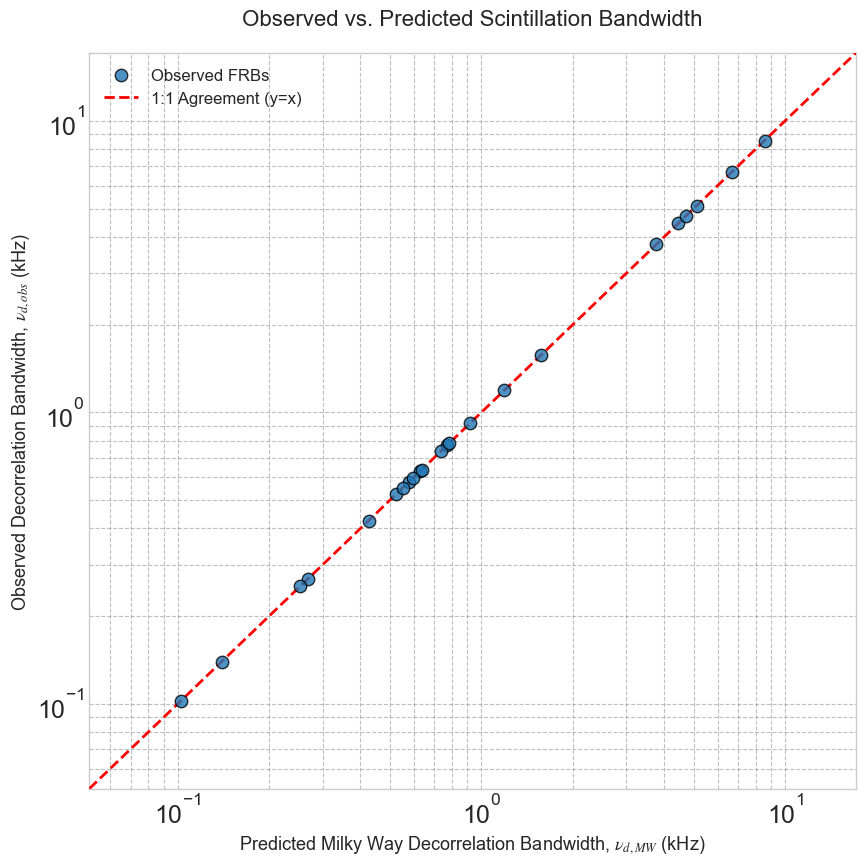

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd

def parse_frb_data(filename="DSA-110_CHIMECodetectionBurstProps.txt"):
    """
    Parses the custom text file to extract observed and predicted gamma values.

    Args:
        filename (str): The name of the text file to parse.

    Returns:
        pandas.DataFrame: A DataFrame with columns for Burst_ID, 
                          Avg_Observed_Gamma_kHz, and NE2001_Predicted_Gamma_kHz.
    """
    
    all_bursts_data = []

    with open(filename, 'r') as f:
        # Skip the header line
        next(f)
        
        for line in f:
            # The data for each burst is separated by a comma, but the fields themselves
            # can contain commas and newlines, so we split carefully.
            parts = line.strip().split(',')
            
            # The burst ID is the first part.
            burst_id = parts[0].strip("'")
            
            # The NE2001 predicted gamma is always at the very end of the line.
            # We use regex to be robust.
            predicted_gamma_match = re.search(r"gamma:\s*([\d.]+)", line)
            if not predicted_gamma_match:
                continue # Skip if no predicted value found
            
            predicted_gamma = float(predicted_gamma_match.group(1))

            # Find all observed gamma values (l_1_gamma, l_2_gamma, etc.) in the line.
            observed_gamma_matches = re.findall(r"l_\d_gamma:\s*([\d.]+)", line)
            
            if not observed_gamma_matches:
                continue # Skip if no observed values found
            
            # Convert found string values to float
            observed_gammas = [float(g) for g in observed_gamma_matches]
            
            # Calculate the average of the observed values
            avg_observed_gamma = np.mean(observed_gammas)
            
            all_bursts_data.append({
                "Burst_ID": burst_id,
                "Avg_Observed_Gamma_kHz": avg_observed_gamma,
                "NE2001_Predicted_Gamma_kHz": predicted_gamma
            })

    return pd.DataFrame(all_bursts_data)

def create_plot(df):
    """
    Generates and saves the scatter plot from the parsed FRB data.
    
    Args:
        df (pandas.DataFrame): The DataFrame containing the processed burst data.
    """
    # Use a clean and professional plot style
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(9, 9))

    # Create the scatter plot
    ax.scatter(df['NE2001_Predicted_Gamma_kHz'], df['Avg_Observed_Gamma_kHz'],
               s=80, alpha=0.8, edgecolors='k', zorder=10, label='Observed FRBs')

    # Determine the plot boundaries to ensure all data is visible
    all_values = pd.concat([df['NE2001_Predicted_Gamma_kHz'], df['Avg_Observed_Gamma_kHz']])
    min_val = all_values[all_values > 0].min() * 0.5  # start slightly below the min value
    max_val = all_values.max() * 2 # extend slightly beyond the max value

    # Plot the red dashed line representing perfect y=x agreement
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, zorder=5, label='1:1 Agreement (y=x)')

    # Use a logarithmic scale to better visualize data spanning orders of magnitude
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Set labels and title with LaTeX for scientific notation
    ax.set_xlabel('Predicted Milky Way Decorrelation Bandwidth, $\\nu_{d, MW}$ (kHz)', fontsize=13)
    ax.set_ylabel('Observed Decorrelation Bandwidth, $\\nu_{d, obs}$ (kHz)', fontsize=13)
    ax.set_title('Observed vs. Predicted Scintillation Bandwidth', fontsize=16, pad=20)

    # Set the axis limits based on the data range
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)

    # Add a legend and a grid for readability
    ax.legend(fontsize=12)
    ax.grid(True, which="both", ls="--", color='gray', alpha=0.5)

    # Annotate points that are significantly below the line of agreement
    for _, row in df.iterrows():
        pred = row['NE2001_Predicted_Gamma_kHz']
        obs = row['Avg_Observed_Gamma_kHz']
        # Label points where the observed bandwidth is less than half of the predicted one
        if obs < pred * 0.5:
            ax.text(pred, obs * 1.1, f'{row["Burst_ID"]}',
                    verticalalignment='bottom', horizontalalignment='center',
                    fontsize=9, color='navy', weight='bold')

    # Adjust layout and save the figure
    plt.tight_layout()
    output_filename = 'observed_vs_predicted_gamma_final.png'
    plt.savefig(output_filename, dpi=300)
    
    print(f"Plot has been successfully saved as '{output_filename}'")


# --- Main execution ---
if __name__ == "__main__":
    # 1. Parse the data from the text file
    frb_dataframe = parse_frb_data()
    
    # 2. Create and save the plot
    create_plot(frb_dataframe)


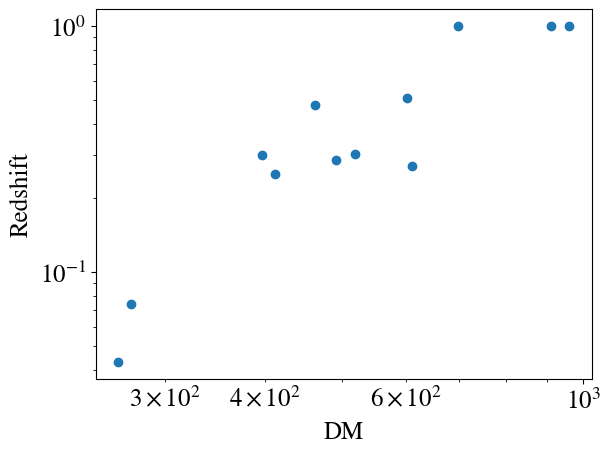

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

plt.close('all')
%matplotlib inline

fig = plt.figure()
plt.scatter(dms, zs)
plt.ylabel('Redshift')
plt.xlabel('DM')
plt.yscale('log')
plt.xscale('log')
plt.show()

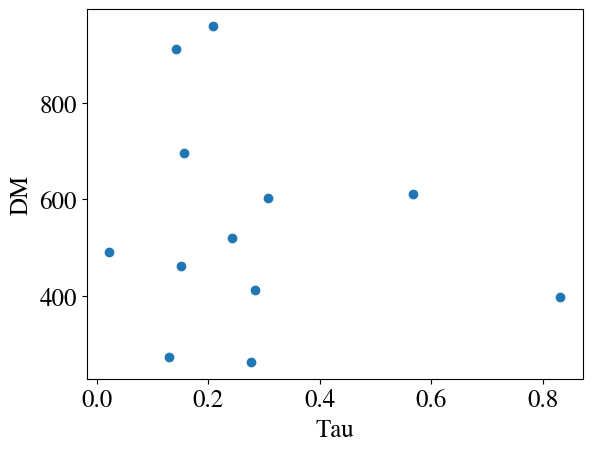

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

plt.close('all')
%matplotlib inline

fig = plt.figure()
plt.scatter(taus, dms)
plt.ylabel('DM')
plt.xlabel('Tau')
#plt.yscale('log')
#plt.xscale('log')
plt.show()

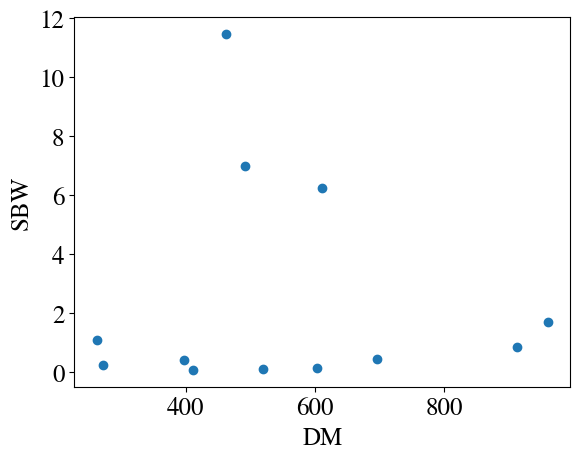

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

plt.close('all')
%matplotlib inline

fig = plt.figure()
plt.scatter(dms, sbws)
plt.ylabel('SBW')
plt.xlabel('DM')
#plt.yscale('log')
#plt.xscale('log')
plt.show()

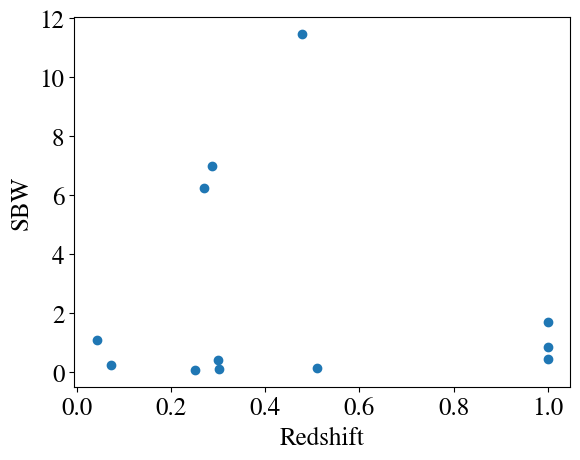

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

plt.close('all')
%matplotlib inline

fig = plt.figure()
plt.scatter(zs, sbws)
plt.ylabel('SBW')
plt.xlabel('Redshift')
#plt.yscale('log')
#plt.xscale('log')
plt.show()

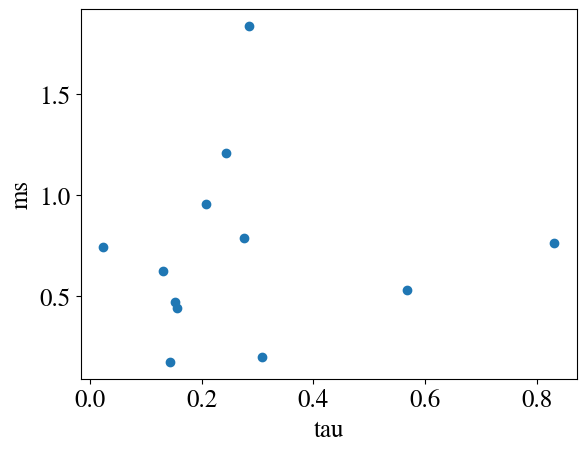

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

plt.close('all')
%matplotlib inline

fig = plt.figure()
plt.scatter(taus, ms)
plt.ylabel('ms')
plt.xlabel('tau')
#plt.yscale('log')
#plt.xscale('log')
plt.show()

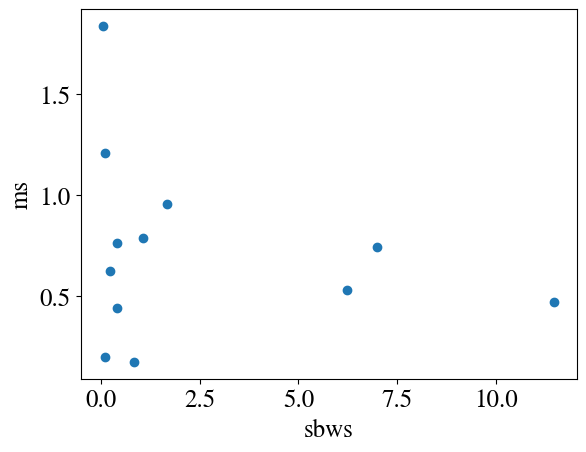

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

plt.close('all')
%matplotlib inline

fig = plt.figure()
plt.scatter(sbws, ms)
plt.ylabel('ms')
plt.xlabel('sbws')
#plt.yscale('log')
#plt.xscale('log')
plt.show()